# Predicting Scope 3 Emissions
### XGBoost and Random Forest Machine Learning Models
##### (*Post-Outlier Removal and Post-Skew Transformation*)

In [1]:
# DataFrames and Plotting
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score

# Notebook
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Load final csv file into a DataFrame
df = pd.read_csv('Final_GHG_Data.csv')
df.head()

account_name  account_id  Year incorporated_country Primary activity  \
0     3i Group          44  2018       United Kingdom   Asset managers   
1     3i Group          44  2018       United Kingdom   Asset managers   
2     3i Group          44  2018       United Kingdom   Asset managers   
3     3i Group          44  2018       United Kingdom   Asset managers   
4     3i Group          44  2018       United Kingdom   Asset managers   

       Primary sector  Market_Cap_USD  \
0  Financial services   9548123536.43   
1  Financial services   9548123536.43   
2  Financial services   9548123536.43   
3  Financial services   9548123536.43   
4  Financial services   9548123536.43   

                            Third_party_verification   Revenue_USD  \
0  Third-party verification or assurance process ... 1728470000.00   
1  Third-party verification or assurance process ... 1728470000.00   
2  Third-party verification or assurance process ... 1728470000.00   
3  Third-party verification or assurance process ... 1728470000.00   
4  Third-party verification or assurance process ... 1728470000.00   

     ebitda_USD  ...  totalInvestments_USD  totalDebt_USD  totalEquity_USD  \
0 1565910000.00  ...         8544560000.00   730250000.00   10044430000.00   
1 1565910000.00  ...         8544560000.00   730250000.00   10044430000.00   
2 1565910000.00  ...         8544560000.00   730250000.00   10044430000.00   
3 1565910000.00  ...         8544560000.00   730250000.00   10044430000.00   
4 1565910000.00  ...         8544560000.00   730250000.00   10044430000.00   

                              Scope_3_emissions_type  \
0                       Purchased goods and services   
1  Fuel-and-energy-related activities (not includ...   
2                      Waste generated in operations   
3                                    Business travel   
4                                 Employee commuting   

   Scope_3_emissions_amount  country_ghg_avg  country_population_avg  \
0                     17.62           428.77             67346924.78   
1                     61.42           428.77             67346924.78   
2                     57.21           428.77             67346924.78   
3                   2549.33           428.77             67346924.78   
4                      3.90           428.77             67346924.78   

   country_gdp_avg  Quantile_Market_Cap_USD  BoxCox_Market_Cap_USD  
0 3038320070320.49                     0.11                  18.48  
1 3038320070320.49                     0.11                  18.48  
2 3038320070320.49                     0.11                  18.48  
3 3038320070320.49                     0.11                  18.48  
4 3038320070320.49                     0.11                  18.48  

[5 rows x 27 columns]

In [5]:
df.columns.unique()

Index(['account_name', 'account_id', 'Year', 'incorporated_country',
       'Primary activity', 'Primary sector', 'Market_Cap_USD',
       'Third_party_verification', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_type',
       'Scope_3_emissions_amount', 'country_ghg_avg', 'country_population_avg',
       'country_gdp_avg', 'Quantile_Market_Cap_USD', 'BoxCox_Market_Cap_USD'],
      dtype='object')

## Correlation Analysis
Check for correlation on each numerical feature to Scope 3 emissions amount.

Because the machine learning model will need to predict by Emission type, I will attempt plot the average correlation for each emission type.

#### **Correlation Heatmap**: *y Target to X Variables*

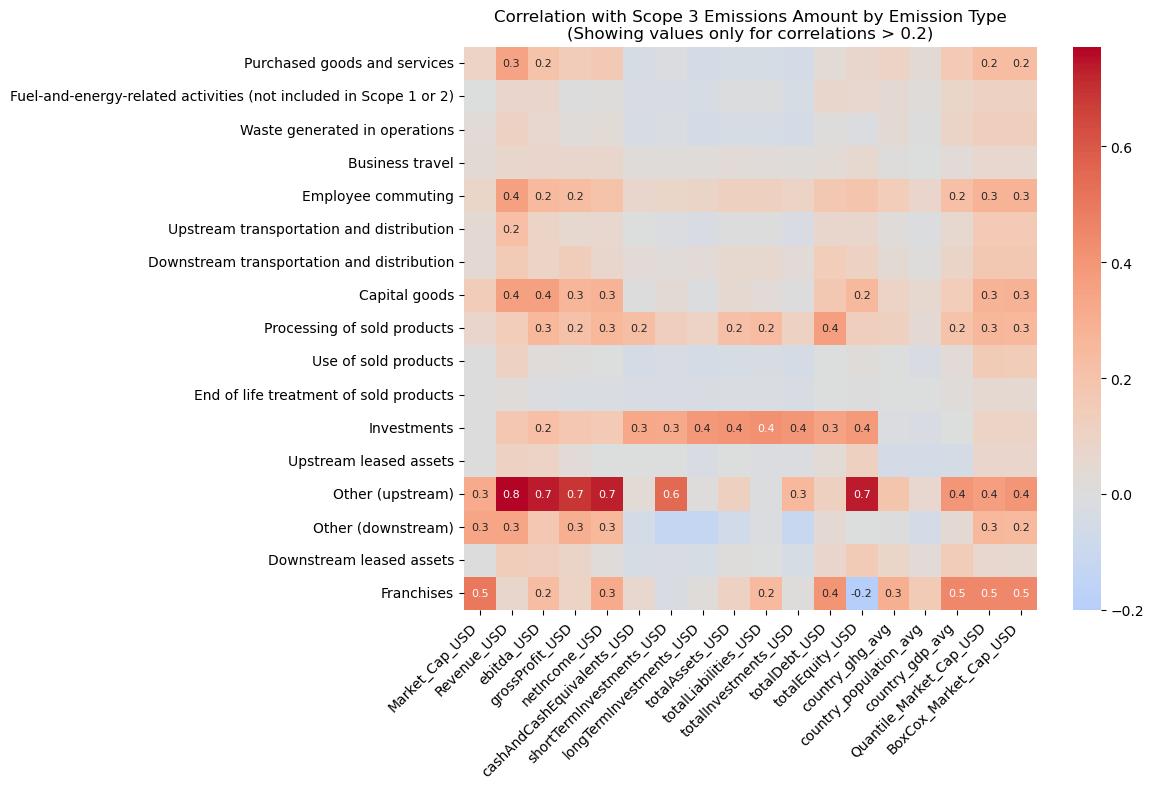

In [9]:
# Calculate X correlations for each Scope 3 emissions type
correlations = []
emission_types = df['Scope_3_emissions_type'].unique()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
# remove columns that should not be included
numerical_cols = numerical_cols[numerical_cols != 'Scope_3_emissions_amount'] 
numerical_cols = numerical_cols[numerical_cols != 'Year'] 
numerical_cols = numerical_cols[numerical_cols != 'account_id'] 

# loop through each type
for emission_type in emission_types:
    subset = df[df['Scope_3_emissions_type'] == emission_type]
    corr = subset[numerical_cols].corrwith(subset['Scope_3_emissions_amount'])
    correlations.append(corr)

# Create DataFrame with the X correlations
corr_df = pd.DataFrame(correlations, index=emission_types)

# Create the annotations array with empty strings for correlations <= 0.2
annot = np.where(np.abs(corr_df) > 0.2, corr_df.round(1).astype(str), '')

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, 
            cmap='coolwarm', center=0, annot=annot, fmt='', annot_kws={'size': 8})

plt.title('Correlation with Scope 3 Emissions Amount by Emission Type\n(Showing values only for correlations > 0.2)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This heatmap assumes linear correlation, but there is no assumption of linear correlation.

#### **Correlation Heatmap**: *Relationship between X Variables*

Because there is strong correlation between varibales, I need to remove some of the variables to reduce X to X correlation.

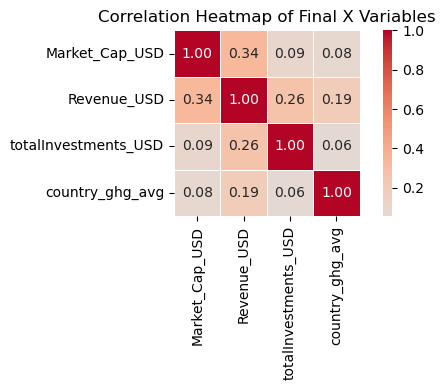

In [13]:
# Columns to drop:
# I will remove the 2 sub-variables for investments so there is only 1 investment variable 
# I will remove the assets and liabilities as these are also sub-variables
# I will remove  country population and GDP as they correlate highly with total GHG and had no correlation to emission amount
# I will remove scaled Market Cap columns and scale all columns as part of the machine learning pipeline
# I will maintain 1 revenue column
numerical_cols = numerical_cols[numerical_cols != 'shortTermInvestments_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'longTermInvestments_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'totalAssets_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'totalLiabilities_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'totalDebt_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'cashAndCashEquivalents_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'country_population_avg'] 
numerical_cols = numerical_cols[numerical_cols != 'country_gdp_avg'] 
numerical_cols = numerical_cols[numerical_cols != 'BoxCox_Market_Cap_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'Quantile_Market_Cap_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'netIncome_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'ebitda_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'totalEquity_USD'] 
numerical_cols = numerical_cols[numerical_cols != 'grossProfit_USD'] 

# Re-create correlation matrix showing all values
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f', linewidths=0.5, annot_kws={'size': 10}) 
plt.title('Correlation Heatmap of Final X Variables')
plt.tight_layout()
plt.show()

#### *List correlations that are over .2 in the new set of variables*

In [15]:
# Initialize empty list before the loop
correlations = []  # Added this line to ensure clean start

for emission_type in emission_types:
    subset = df[df['Scope_3_emissions_type'] == emission_type]
    # Calculate correlation for this specific emission type
    corr = subset[numerical_cols].corrwith(subset['Scope_3_emissions_amount'])
    # Append as a single row
    correlations.append(corr)

# Create DataFrame with correlations - ensure index and data match
corr_df = pd.DataFrame(correlations, index=emission_types, columns=numerical_cols)  # Added columns parameter

# Find correlations over 0.2
high_correlations = []
for emission_type in emission_types:
    for column in numerical_cols:
        correlation = corr_df.loc[emission_type, column]
        if abs(correlation) > 0.2:
            high_correlations.append({
                'Emission Type': emission_type,
                'Feature': column,
                'Correlation': correlation
            })

# Convert to DataFrame and sort by absolute correlation
high_corr_df = pd.DataFrame(high_correlations)
high_corr_df = high_corr_df.sort_values(by='Correlation', key=abs, ascending=False)
high_corr_df

Emission Type               Feature  \
6                           Other (upstream)           Revenue_USD   
10                                Franchises        Market_Cap_USD   
4                                Investments  totalInvestments_USD   
1                         Employee commuting           Revenue_USD   
3                              Capital goods           Revenue_USD   
0               Purchased goods and services           Revenue_USD   
9                         Other (downstream)           Revenue_USD   
8                         Other (downstream)        Market_Cap_USD   
5                           Other (upstream)        Market_Cap_USD   
11                                Franchises       country_ghg_avg   
7                           Other (upstream)  totalInvestments_USD   
2   Upstream transportation and distribution           Revenue_USD   

    Correlation  
6          0.77  
10         0.50  
4          0.40  
1          0.36  
3          0.36  
0          0.35  
9          0.34  
8          0.34  
5          0.32  
11         0.30  
7          0.25  
2          0.22

#### Drop variables from df

In [19]:
drop_columns = [   
    'Third_party_verification'
    ,'incorporated_country'
    ,'account_name'                   
    ,'shortTermInvestments_USD'
    ,'longTermInvestments_USD'
    ,'totalAssets_USD'
    ,'totalLiabilities_USD'
    ,'totalDebt_USD'
    ,'cashAndCashEquivalents_USD'
    ,'country_population_avg'
    ,'country_gdp_avg'
    ,'BoxCox_Market_Cap_USD'
    ,'Quantile_Market_Cap_USD'
    ,'netIncome_USD'
    ,'ebitda_USD'
    ,'totalEquity_USD'
    ,'grossProfit_USD'
    ]
df = df.drop(columns=drop_columns)
df.columns.unique()

Index(['account_id', 'Year', 'Primary activity', 'Primary sector',
       'Market_Cap_USD', 'Revenue_USD', 'totalInvestments_USD',
       'Scope_3_emissions_type', 'Scope_3_emissions_amount',
       'country_ghg_avg'],
      dtype='object')

## Feature Engineering and Modeling

Most Machine Learning models require data encoding for categorical values. There are 2 main encoding methods used:
1. Label encoding
2. One hot encoding

Label encoding assigns a numerical value to every value in a categorical column. This method essentially converts a unique string into a unique number. This route can be problematic to the algorithm if the model assigns value to the numbers beyond categorical limitation. For instance, primary activity has over 50 values. It's safe to assume the model might interpret a value of 1 differently than a value of 50. 

One hot encoding converts every categorical value in each column to a binary value. For machine learning, this is the more ideal option, as it allows every category to be represented by its own binary feature. This prevents the model from assuming an ordinal relationship or ranking  between categories, which can cause inaccurate predictions. Because this dataset includes categorical columns wih many categories, one hot encoding will result in hundreds of features in order to capture every possible categorical value. This will likey result in overly high dimensionality and accumulated feature noise with very little correlation for reliable predictions.

Before deciding which columns to keep for training, I want to encode the categorical features and analyze for any possible correlation.

#### *One Hot Encode Primary Sector and Primary Activity and add to the DataFrame*

In [24]:
# One-hot encode Primary Sector
sector_dummies = pd.get_dummies(df['Primary sector'], prefix='sector')

# Calculate correlations with Scope_3_emissions_amount
sector_correlations = sector_dummies.apply(lambda x: x.corr(df['Scope_3_emissions_amount']))

# Append one-hot encoded columns to original dataframe
df = pd.concat([df, sector_dummies], axis=1)


In [26]:
# One-hot encode Primary Activity
sector_dummies = pd.get_dummies(df['Primary activity'], prefix='activity')

# Calculate correlations with Scope_3_emissions_amount
sector_correlations = sector_dummies.apply(lambda x: x.corr(df['Scope_3_emissions_amount']))

# Append one-hot encoded columns to original dataframe
df = pd.concat([df, sector_dummies], axis=1)

In [28]:
# final shape
df.shape

(37591, 197)

### Remove NULLS
Now that the features have been finalized, I will remove any account that has a null observation. It is possible to utilize the null parameter in XGBoost and the imputer in Random Forest, but as a start, I want a clean and consistent dataset for these intial models to build from. 

In [31]:
# Create a summary dataframe to analyze nulls
summary_df = pd.DataFrame({
    'Data_Type': df.dtypes,
    'Null_Count': df.isnull().sum(),
    'Null_Percentage': (df.isnull().sum() / len(df) * 100).round(2),})

print("\nDataFrame Summary:")
print(summary_df)

# Print total null count
print("\nTotal null values in DataFrame:", df.isnull().sum().sum())

# How many accounts have at least 1 null value?
null_accounts = df[df.isnull().any(axis=1)]['account_id'].nunique()
print(f"Number of accounts with at least one null value: {null_accounts}")


DataFrame Summary:
                                               Data_Type  Null_Count  \
account_id                                         int64           0   
Year                                               int64           0   
Primary activity                                  object           0   
Primary sector                                    object           0   
Market_Cap_USD                                   float64           0   
...                                                  ...         ...   
activity_Vehicles & machinery rental & leasing      bool           0   
activity_Waste management                           bool           0   
activity_Water supply networks                      bool           0   
activity_Wind generation                            bool           0   
activity_Wood furniture                             bool           0   

                                                Null_Percentage  
account_id                                       

#### *Remove Accounts with at least one NULL observation*

In [34]:
# Get initial unique account count
initial_accounts = df['account_id'].nunique()
initial_account_list = set(df['account_id'].unique())

# Remove rows with any null values
df_clean = df.dropna(axis=0, how='any')

# Get final unique account count
final_accounts = df_clean['account_id'].nunique()
final_account_list = set(df_clean['account_id'].unique())

# Calculate removed accounts
removed_accounts = initial_account_list - final_account_list

# Print summary statistics
print(f"Initial number of unique accounts: {initial_accounts}")
print(f"Final number of unique accounts: {final_accounts}")
print(f"Number of unique accounts removed: {len(removed_accounts)}")
print(f"Percentage of unique accounts removed: {(len(removed_accounts) / initial_accounts * 100):.2f}%")

# Verify no null values remain
print("\nVerifying no null values remain:")
null_check = df_clean.isnull().sum()
print(null_check[null_check > 0] if len(null_check[null_check > 0]) > 0 else "No null values remaining")

Initial number of unique accounts: 966
Final number of unique accounts: 957
Number of unique accounts removed: 9
Percentage of unique accounts removed: 0.93%

Verifying no null values remain:
No null values remaining


In [36]:
# Reassign to original dataframe
df = df_clean

# Create a point in time of this original dataframe
df_original = df

In [38]:
# final removal of encoded columns
drop_columns = ['account_id','Primary sector', 'Primary activity']
df = df.drop(columns=drop_columns)
df.columns.unique()

Index(['Year', 'Market_Cap_USD', 'Revenue_USD', 'totalInvestments_USD',
       'Scope_3_emissions_type', 'Scope_3_emissions_amount', 'country_ghg_avg',
       'sector_0', 'sector_Accessories', 'sector_Air transport',
       ...
       'activity_Tobacco products', 'activity_Toys & games',
       'activity_Transportation infrastructure & other construction',
       'activity_Transportation support services', 'activity_Travel services',
       'activity_Vehicles & machinery rental & leasing',
       'activity_Waste management', 'activity_Water supply networks',
       'activity_Wind generation', 'activity_Wood furniture'],
      dtype='object', length=194)

# Machine Learning
I believe the models that best suit the nature of this data include:
#### 1. **Random Forest**
#### 2. **XGBoost**

Both models work well for the follwing reasons:

- Both are able to handle complex data relationships, which is a characteristic of Scope 3 emissions data.
- Able to capture non-linear relationships and interactions between variables.
- Robust to outliers, which common in emissions data and are less prone to overfitting.
- Work well with mixed data types (numerical and categorical), which is common in emissions reporting.
- Feature Importance: Both provide clear insights into which factors most influence emissions and can help identify key areas for emissions reduction.
- Scope 3 data frequently has gaps due to reporting challenges. While missing data was removed from the final dataset, it would be worthwhile to also test the models without data removal and compare the results as both models do well with handling missing values.
    - Random Forest can operate with missing data without imputation
    - XGBoost has built-in methods for missing value handling

##### **Model Design**
The algorithms will train on a time-series of all previous years in conjunction with numerical features in order to predict the most recent observation (Year 2023) within each Emission type.

##### **MAE (Mean Absolute Error)**
Performance will be analyzed using MAE. MAE measures the average magnitude of errors between predicted and actual values, without considering their direction (high or low). It is best in this prediction scenario because:

- The absolute scale of errors matters, as the absolute difference between actual and predicted emission amounts is highly important.
- MAE is in the same unit as the emission amount and both over and under-predictions are equally important.
- Direct, interpretable results and error measurements are needed in this scenario (MAE is more interpretable than percentage-based errors).
- Outliers exist but shouldn't dominate the error metric (MAE is more robust to outliers than squared metrics, such as MSE and RMSE).

## Random Forest

#### *Build the Model*

This code:
1. Creates a pipeline with preprocessing (StandardScaler for numeric features) and a RandomForestRegressor for the model
2. Uses TimeSeriesSplit for proper time series validation on Year
3. Processes each emission type separately
4. Calculates MAE for each emission type

This approach provides a robust way to analyze and predict emissions while maintaining the time series nature of the data and handling different emission types separately.

In [330]:
# Initialize results storage
results_dict = {}

# Get unique emission types
emission_types = df['Scope_3_emissions_type'].unique()

# Identify numeric columns to scale (excluding Year, target, and encoded categorical features)
all_numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
columns_to_scale = [col for col in all_numeric_columns 
                   if col not in ['Year', 'Scope_3_emissions_amount','account_id']
                   and not col.startswith(('sector_', 'activity_'))]
categorical_columns = [col for col in df.columns 
                      if col.startswith(('sector_', 'activity_'))]

# Create preprocessing steps for StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Get feature names after preprocessing
feature_names = (columns_to_scale + 
                ['Year'] + 
                categorical_columns)

# Create pipeline with preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

for emission_type in emission_types:
    # Filter data for current emission type
    emission_df = df[df['Scope_3_emissions_type'] == emission_type].copy()
    
    # Sort by Year to ensure chronological order
    emission_df = emission_df.sort_values('Year')
    
    # Get the most recent year
    max_year = emission_df['Year'].max()
    
    # Split data into train (previous years) and test (most recent year)
    train_data = emission_df[emission_df['Year'] < max_year]
    test_data = emission_df[emission_df['Year'] == max_year]
    
    # Prepare features and target
    X_train = train_data[columns_to_scale + ['Year'] + categorical_columns].copy()
    y_train = train_data['Scope_3_emissions_amount']
    
    X_test = test_data[columns_to_scale + ['Year'] + categorical_columns].copy()
    y_test = test_data['Scope_3_emissions_amount']
    
    # Fit pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate MAE
    mae = np.mean(np.abs(y_test - y_pred))
    
    # Store results in dictionary with emission_type as key
    results_dict[emission_type] = {
        'mae': mae,
        'actuals': y_test.tolist(),
        'predictions': y_pred.tolist(),
        'prediction_year': max_year
    }

# Print MAE for each emission type
print("\nMAE by Emission Type for Most Recent Year:")
for emission_type, metrics in results_dict.items():
    print(f"Emission Type: {emission_type}")
    print(f"Prediction Year: {metrics['prediction_year']}")
    print(f"MAE: {metrics['mae']:,.2f}")
    print(f"Number of predictions: {len(metrics['predictions'])}")
    print("-" * 50)


MAE by Emission Type for Most Recent Year:
Emission Type: Purchased goods and services
Prediction Year: 2023
MAE: 945,559.11
Number of predictions: 798
--------------------------------------------------
Emission Type: Fuel-and-energy-related activities (not included in Scope 1 or 2)
Prediction Year: 2023
MAE: 404,306.31
Number of predictions: 747
--------------------------------------------------
Emission Type: Waste generated in operations
Prediction Year: 2023
MAE: 19,413.07
Number of predictions: 756
--------------------------------------------------
Emission Type: Business travel
Prediction Year: 2023
MAE: 19,577.21
Number of predictions: 848
--------------------------------------------------
Emission Type: Employee commuting
Prediction Year: 2023
MAE: 20,153.99
Number of predictions: 741
--------------------------------------------------
Emission Type: Upstream transportation and distribution
Prediction Year: 2023
MAE: 331,606.25
Number of predictions: 618
-----------------------

In [331]:
# Convert results dictionary to DataFrame

# Create empty lists to store the data
rows = []

# Iterate through the dictionary and create individual rows
for emission_type, results in results_dict.items():
    mae = results['mae']
    actuals = results['actuals']
    predictions = results['predictions']
    
    # Create a row for each actual/prediction pair
    for actual, pred in zip(actuals, predictions):
        rows.append({
            'emission_type': emission_type,
            'actuals': actual,
            'predictions': pred,
            'mae': mae
        })

rf_results

emission_type    actuals  predictions       mae
0     Purchased goods and services    1807.00     18707.60 945559.11
1     Purchased goods and services      90.00     83172.99 945559.11
2     Purchased goods and services      65.48    119244.71 945559.11
3     Purchased goods and services 2663484.05   1833241.19 945559.11
4     Purchased goods and services    5544.00     64474.22 945559.11
...                            ...        ...          ...       ...
7105                    Franchises  475576.00    381551.79 178530.20
7106                    Franchises     277.00    278279.34 178530.20
7107                    Franchises 2972102.00   1687195.97 178530.20
7108                    Franchises   15358.00     23515.29 178530.20
7109                    Franchises    2407.00     49660.67 178530.20

[7110 rows x 4 columns]

#### *Vizualize Results*

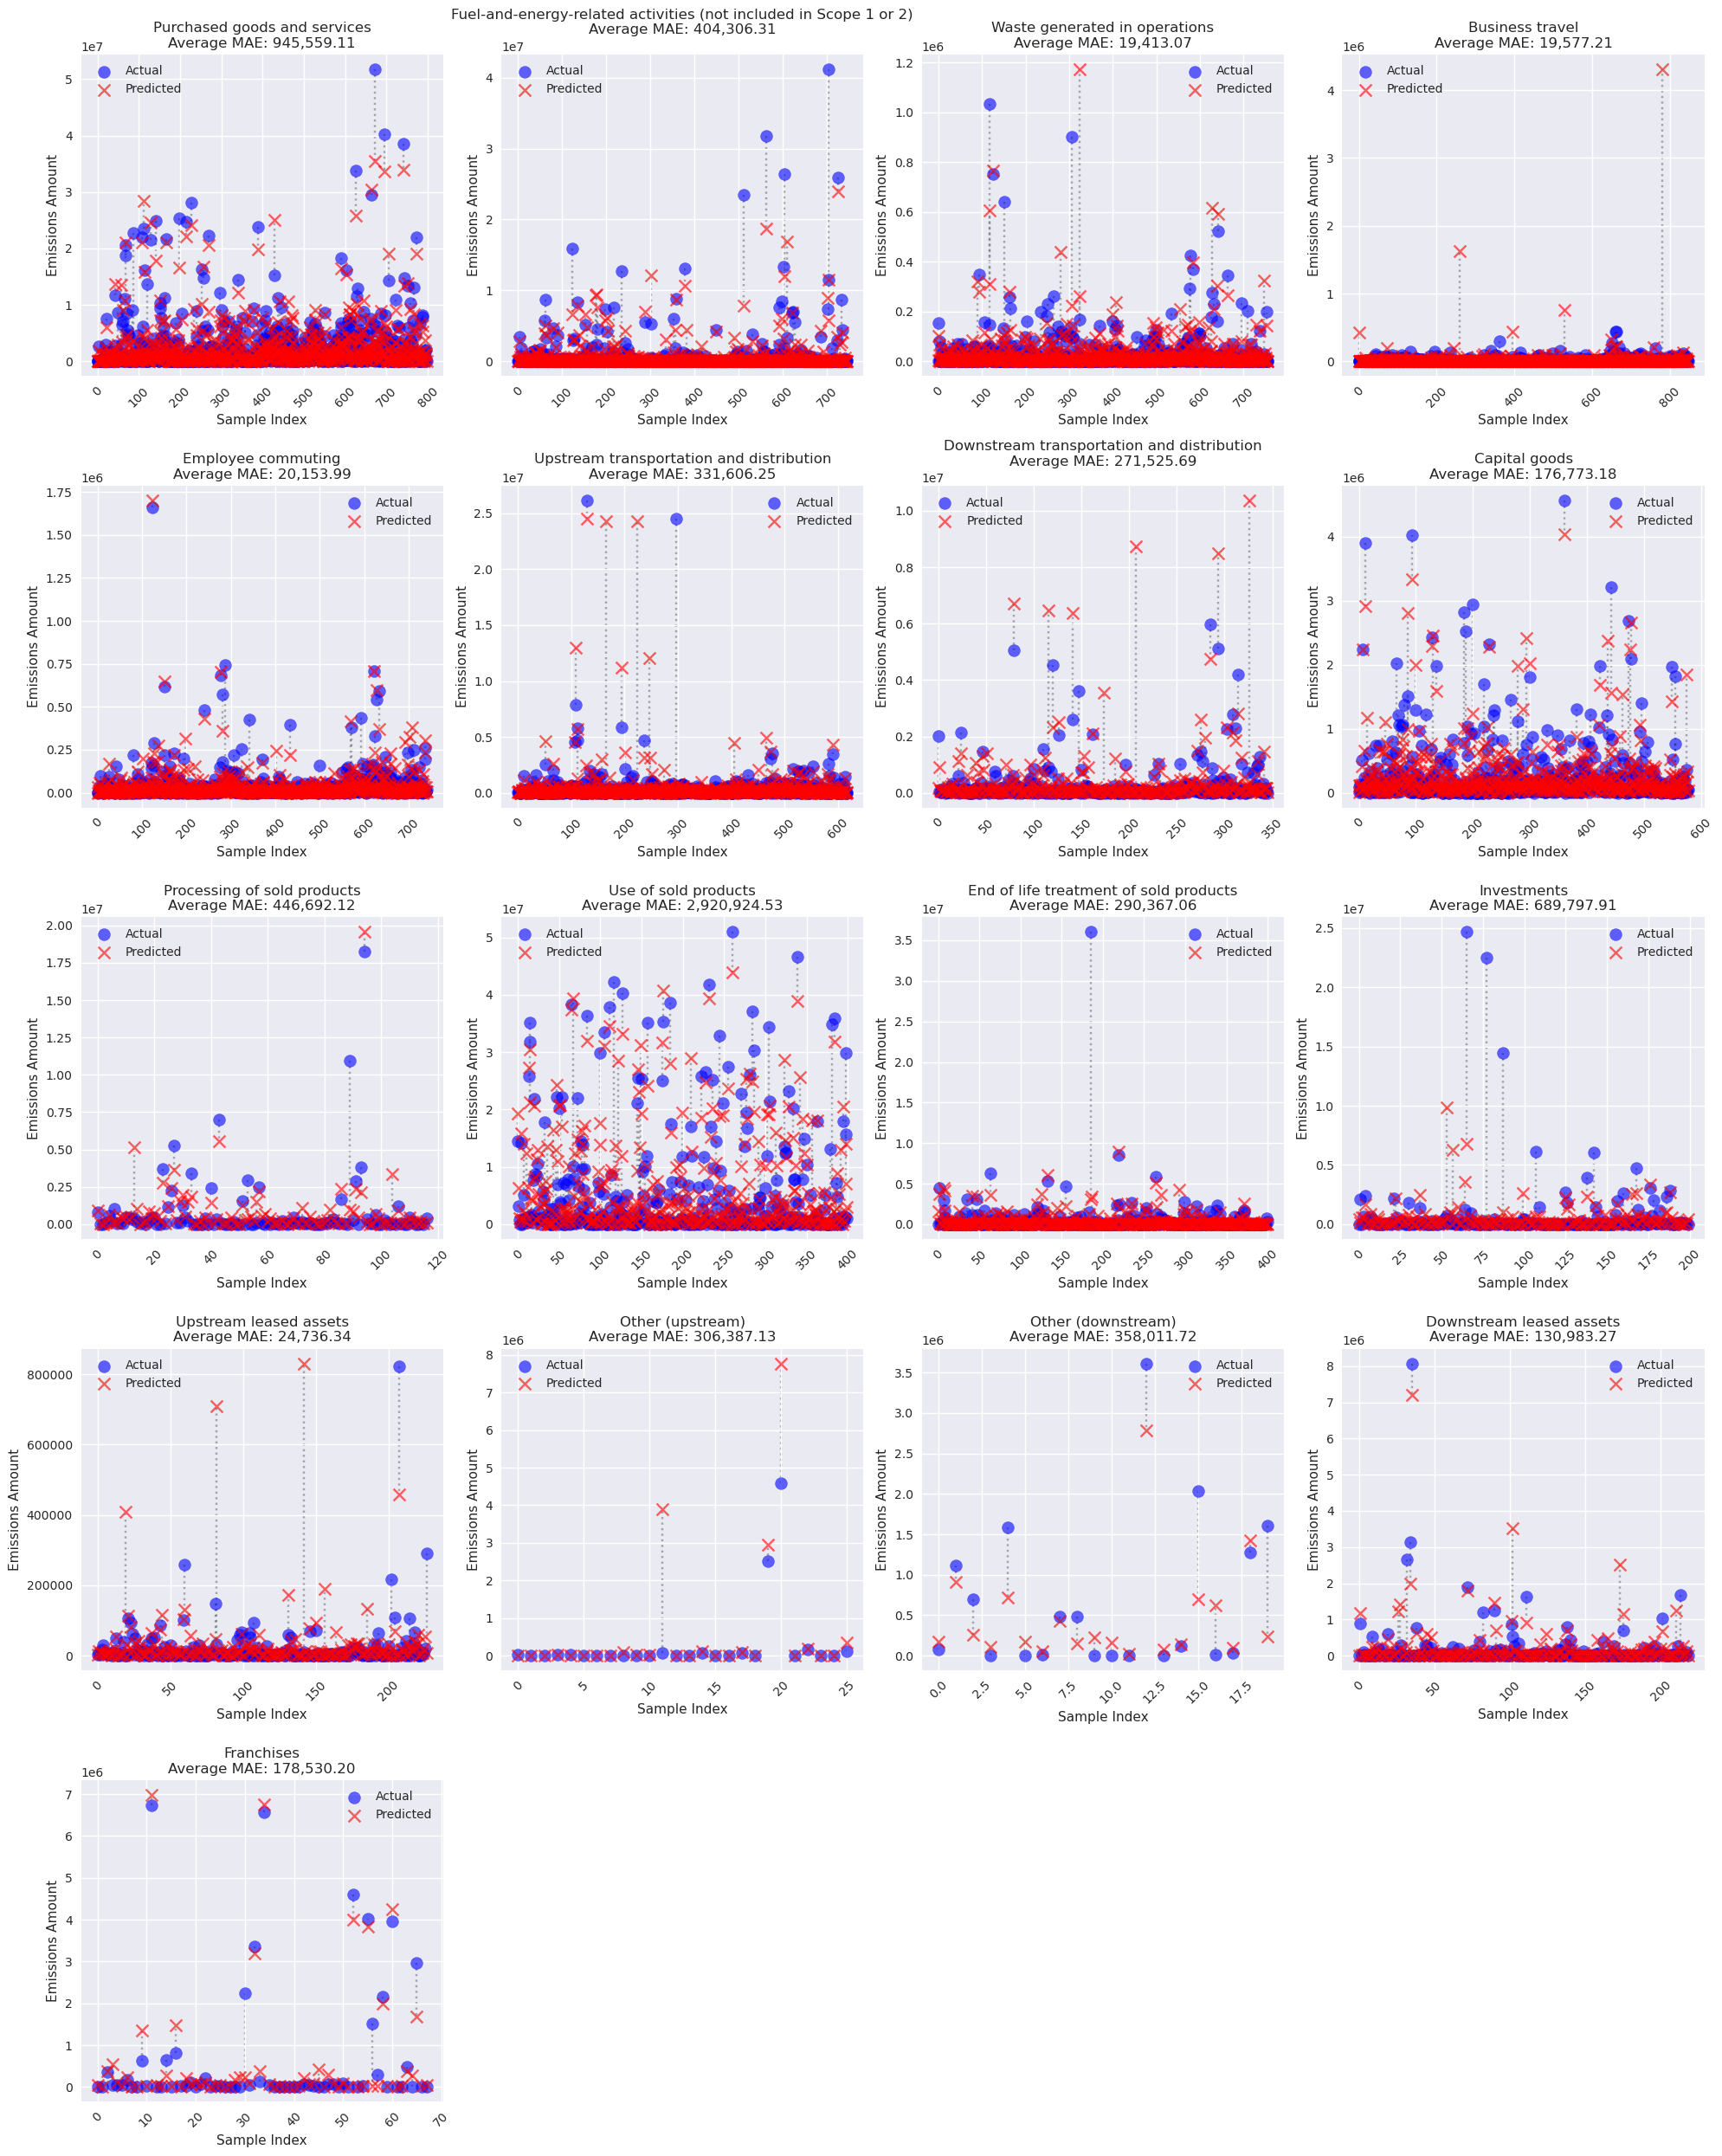

In [333]:
# Calculate number of rows needed for 4 columns
n_types = len(rf_results['emission_type'].unique())
n_cols = 4
n_rows = (n_types + 3) // 4  # Ceiling division to ensure enough rows

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# For each emission type
for idx, emission_type in enumerate(rf_results['emission_type'].unique()):
    ax = axes[idx]
    
    # Get data for this emission type
    data = rf_results[rf_results['emission_type'] == emission_type]
    actuals = data['actuals'].values
    predictions = data['predictions'].values
    mae = data['mae'].iloc[0]  # Get MAE (same for all rows of this type)
    
    # Plot actual values (blue dots)
    ax.scatter(range(len(actuals)), actuals, color='blue', alpha=0.6, 
              label='Actual', s=100, zorder=1)
    
    # Plot predicted values (red x's)
    ax.scatter(range(len(predictions)), predictions, color='red', alpha=0.6,
              marker='x', s=100, label='Predicted', zorder=2)
    
    # Draw dotted lines between actual and predicted values
    for i in range(len(actuals)):
        ax.plot([i, i], [actuals[i], predictions[i]], 'k:', alpha=0.3, zorder=0)
    
    # Add title and labels
    ax.set_title(f"{emission_type}\nAverage MAE: {mae:,.2f}")
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Emissions Amount')
    ax.legend()
    
    # Rotate x-axis labels if needed
    plt.setp(ax.get_xticklabels(), rotation=45)

# Remove any empty subplots
for idx in range(len(rf_results['emission_type'].unique()), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

### *Prediction Variance*

##### *Variance Dataframe*

In [336]:
# Calculate variances for each emission type with individual prediction details
variance_data = []
prediction_index = 0

for emission_type, data in results_dict.items():
    actuals = np.array(data['actuals'])
    predictions = np.array(data['predictions'])
    
    # Calculate absolute differences (variance) between actual and predicted
    variances = (actuals - predictions)
    
    # Store data for each individual prediction
    for actual, predicted, variance in zip(actuals, predictions, variances):
        variance_data.append({
            'Emission_Type': emission_type,
            'Actual': actual,
            'Predicted': predicted,
            'Variance': variance,
            'Prediction_Index': prediction_index
        })
        prediction_index += 1

# Convert to DataFrame
variance_df = pd.DataFrame(variance_data)
variance_df

Emission_Type     Actual  Predicted   Variance  \
0     Purchased goods and services    1807.00   18707.60  -16900.60   
1     Purchased goods and services      90.00   83172.99  -83082.99   
2     Purchased goods and services      65.48  119244.71 -119179.23   
3     Purchased goods and services 2663484.05 1833241.19  830242.86   
4     Purchased goods and services    5544.00   64474.22  -58930.22   
...                            ...        ...        ...        ...   
7105                    Franchises  475576.00  381551.79   94024.21   
7106                    Franchises     277.00  278279.34 -278002.34   
7107                    Franchises 2972102.00 1687195.97 1284906.03   
7108                    Franchises   15358.00   23515.29   -8157.29   
7109                    Franchises    2407.00   49660.67  -47253.67   

      Prediction_Index  
0                    0  
1                    1  
2                    2  
3                    3  
4                    4  
...                ...  
7105              7105  
7106              7106  
7107              7107  
7108              7108  
7109              7109  

[7110 rows x 5 columns]

#### **Prediction Variance**: *Scatterplot of all Predictions by Emissions Type*

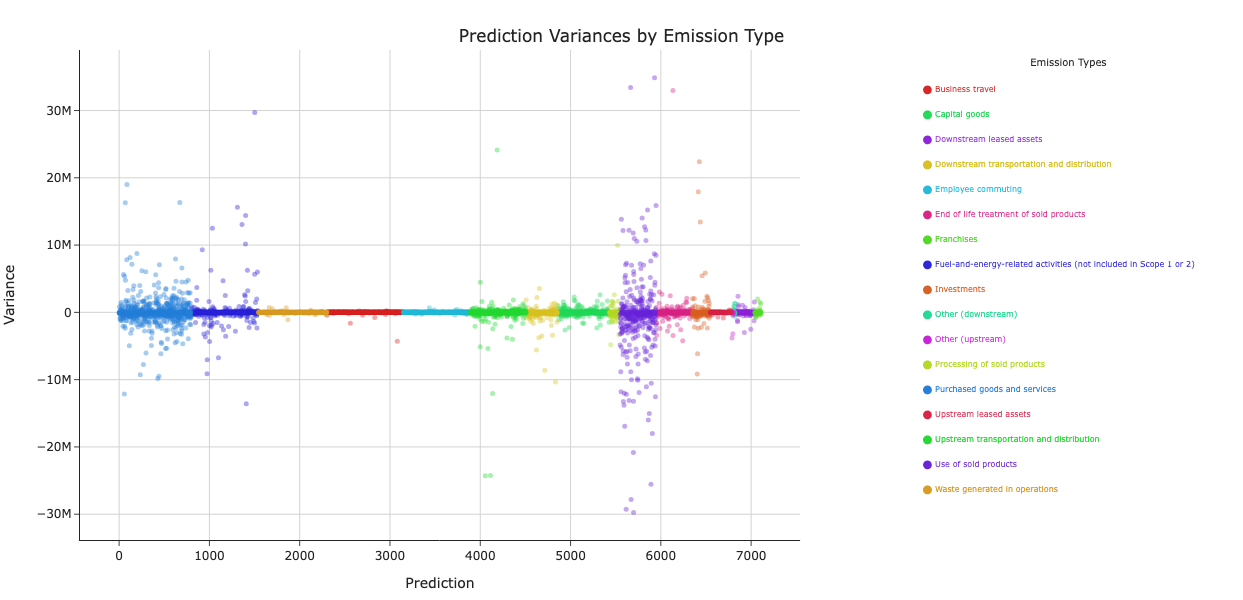

In [338]:
# Sort the DataFrame by Emission_Type to group colors together
variance_df = variance_df.sort_values(['Emission_Type', 'Prediction_Index'])

# Create figure with secondary y-axis
fig = make_subplots(
    rows=1, 
    cols=2,
    column_widths=[0.7, 0.3],  # 70% for plot, 30% for legend
    specs=[[{"type": "scatter"}, {"type": "table"}]]
)

# Function to generate distinct colors based on index
def get_color(idx):
    # Using HSL color space for better distribution of colors
    hue = (idx * 137.5) % 360  # Golden angle approximation for better distribution
    return f'hsl({hue}, 70%, 50%)'

# Add scatter plots for each emission type
for idx, emission_type in enumerate(variance_df['Emission_Type'].unique()):
    temp_df = variance_df[variance_df['Emission_Type'] == emission_type]
    
    # Add scatter trace
    fig.add_trace(
        go.Scatter(
            x=temp_df['Prediction_Index'],
            y=temp_df['Variance'],
            name=emission_type,
            mode='markers',
            marker=dict(
                color=get_color(idx),
                size=5,
                opacity=0.4,
                symbol='circle'
            ),
            hovertemplate=(
                "<b>%{text}</b><br>" +
                "Index: %{x}<br>" +
                "Variance: %{y:.2f}<br>" +
                "<extra></extra>"
            ),
            text=[emission_type] * len(temp_df)
        ),
        row=1, col=1  # Place in first column
    )

# Add reference line at y=0
fig.add_hline(
    y=0, 
    line_dash="dash", 
    line_color="black",
    row=1, col=1
)

# Create legend as a separate table with colored dots
legend_data = [
    [f'⬤ {emission_type}']  # Unicode circle + emission type
    for idx, emission_type in enumerate(variance_df['Emission_Type'].unique())
]

fig.add_trace(
    go.Table(
        header=dict(values=['Emission Types'],
                   fill_color='white',
                   font=dict(size=10)),
        cells=dict(
            values=[legend_data],
            fill_color='white',
            font=dict(size=8),
            height=25,
            align='left',
            # Add colors to the cells
            font_color=[
                [get_color(idx) for idx, _ in enumerate(variance_df['Emission_Type'].unique())]
            ]
        ),
        columnwidth=[1]
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title={
        'text': 'Prediction Variances by Emission Type',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1000,
    height=600,
    template='simple_white',
    showlegend=False,  # Hide default legend
    xaxis=dict(
        title='Prediction',
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    yaxis=dict(
        title='Variance',
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    margin=dict(r=20, l=20, t=50, b=20)
)

# Update the second subplot to remove axes
fig.update_xaxes(showticklabels=False, showgrid=False, row=1, col=2)
fig.update_yaxes(showticklabels=False, showgrid=False, row=1, col=2)

# Show the plot
fig.show()

#### **Prediction Variance**: *Line Chart with Percentiles*

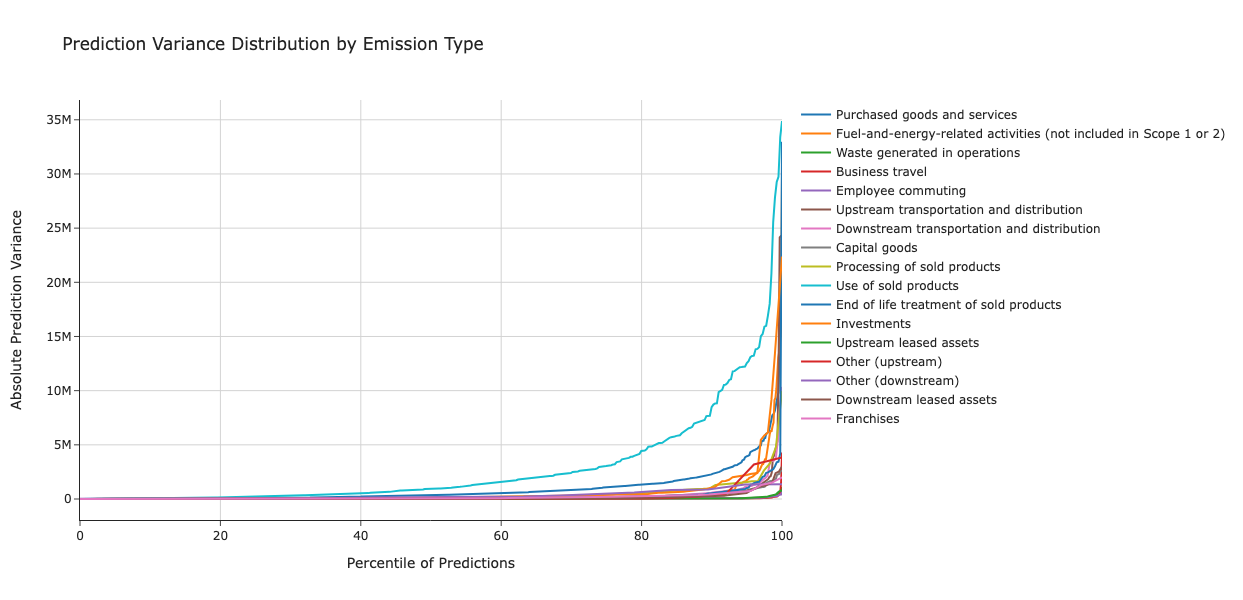

In [340]:
# Create Line Chart
fig = go.Figure()

# Add traces for each emission type
for emission_type in df_variance['Emission_Type'].unique():
    temp_df = df_variance[df_variance['Emission_Type'] == emission_type]
    
    # Sort variances
    sorted_variances = np.sort(temp_df['Variance'].values)
    
    # Create index for x-axis (percentage of predictions)
    x_axis = np.linspace(0, 100, len(sorted_variances))
    
    # Add trace
    fig.add_trace(go.Scatter(
        x=x_axis,
        y=sorted_variances,
        name=emission_type,
        mode='lines',
    ))

# Update layout
fig.update_layout(
    title='Prediction Variance Distribution by Emission Type',
    xaxis_title='Percentile of Predictions',
    yaxis_title='Absolute Prediction Variance',
    width=1200,
    height=600,
    template='simple_white',
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()


# Create scatterplot
fig = go.Figure()

The outliers are pushing the variance into higher percentiles, which is expected. The model has difficulty predicting the highest values. We can look at the prediction variance for each indivual emissions type.

#### **Prediction Variance**: *Actuals vs Predicted for Each Emissions Type*

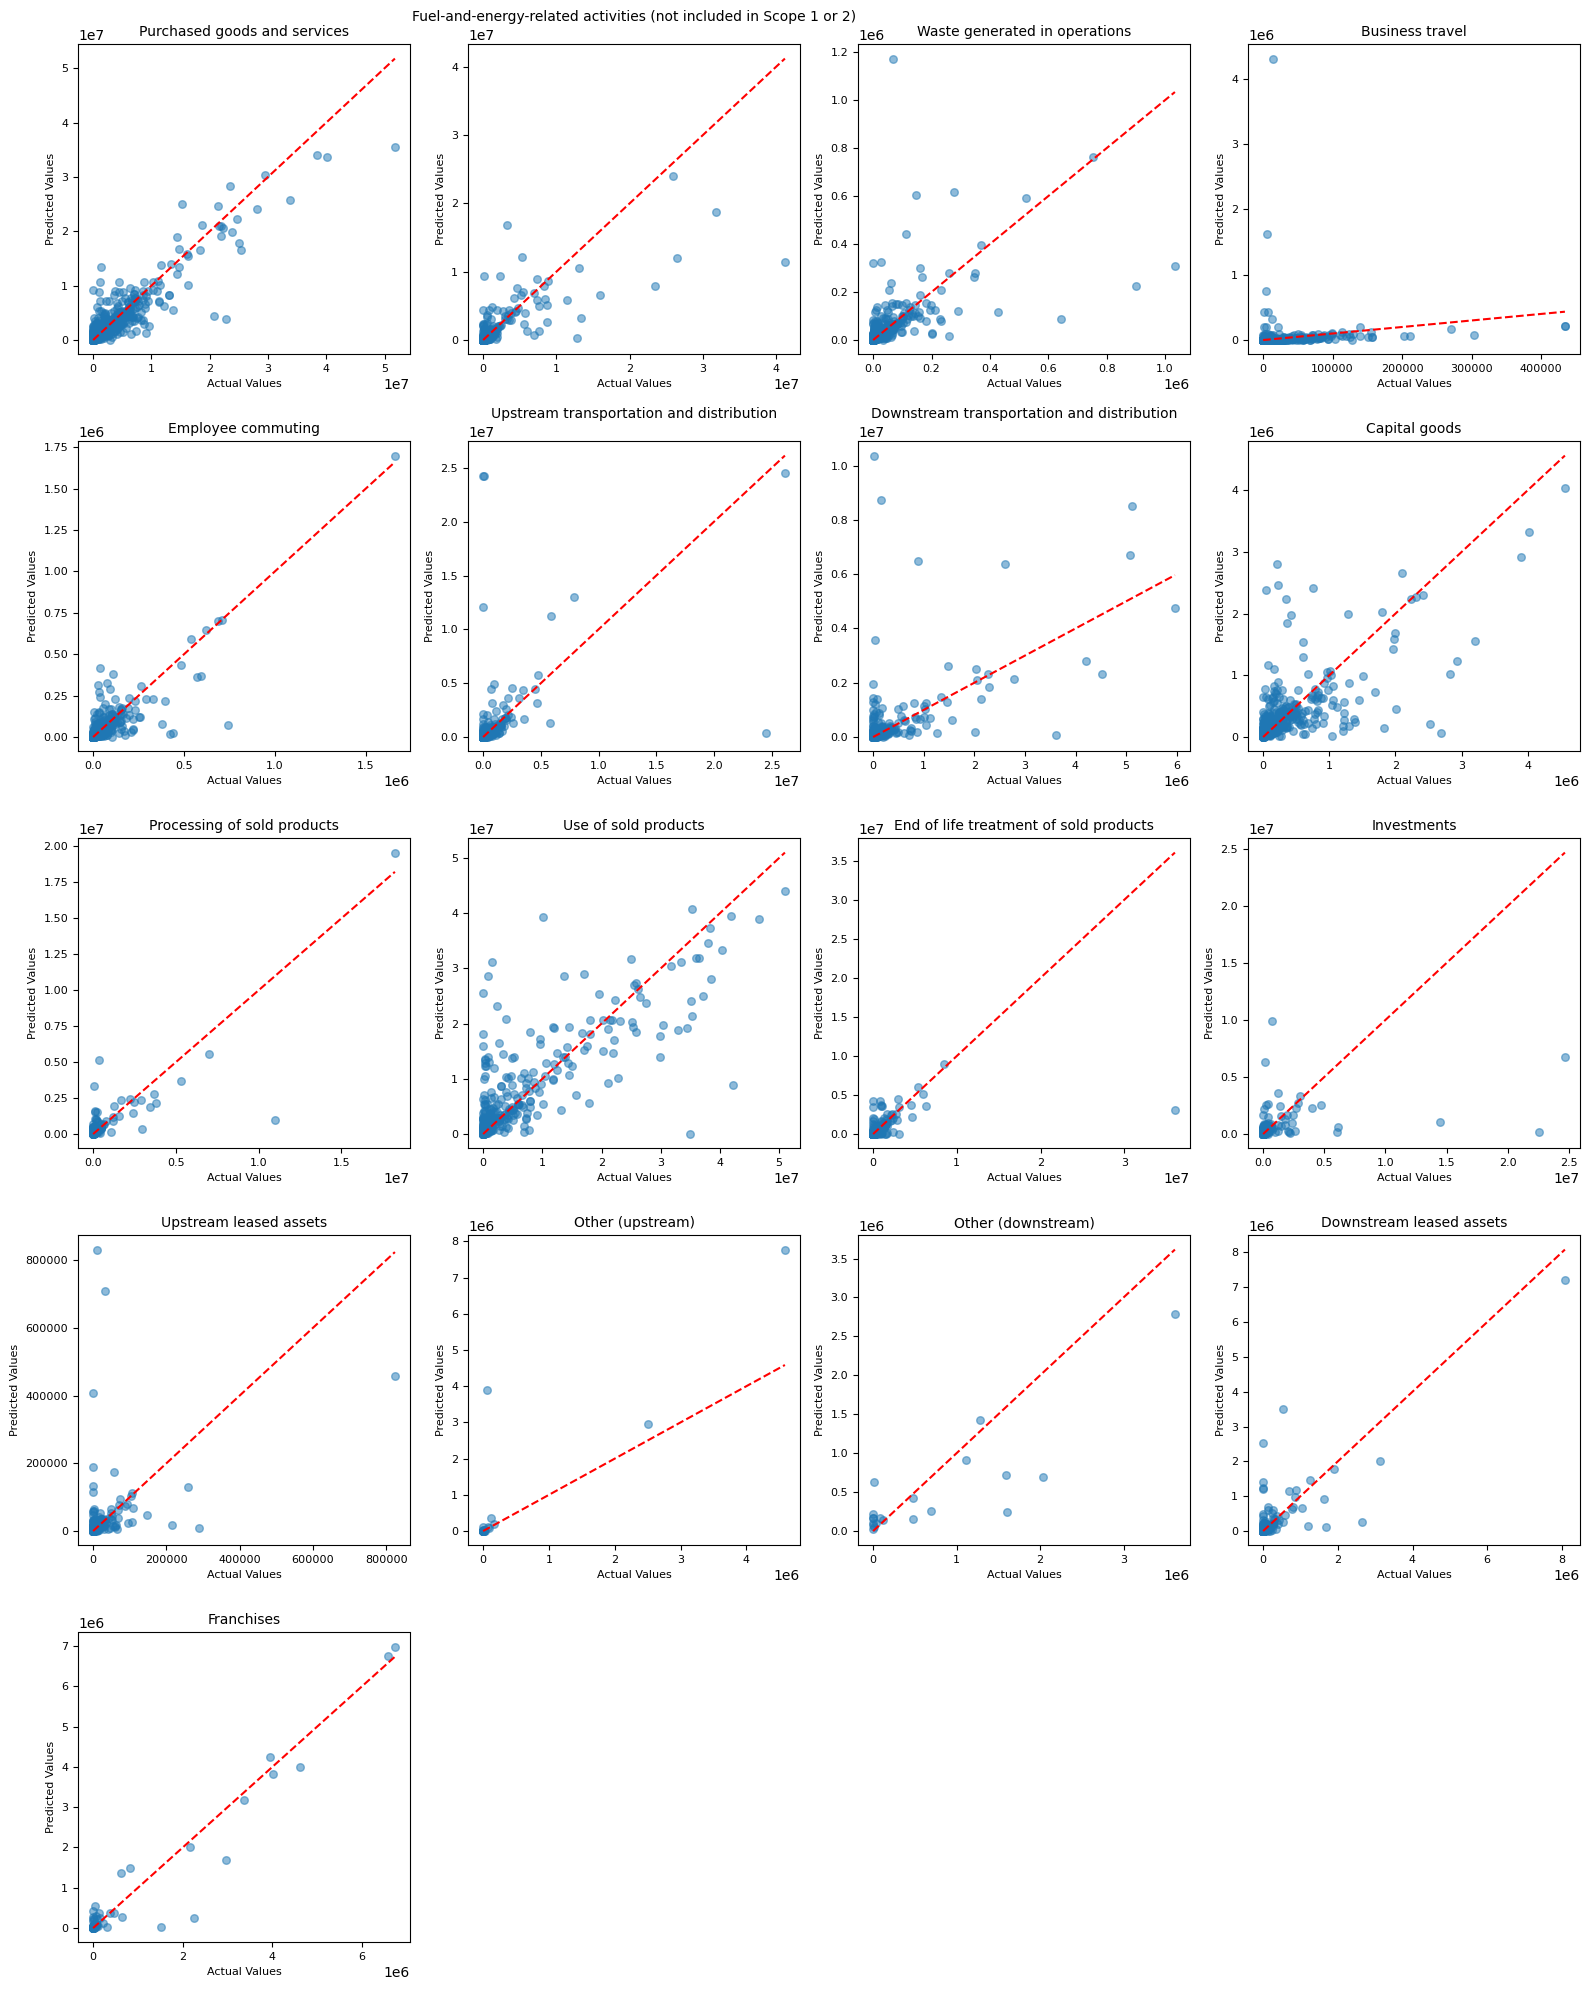

In [128]:
# Actual vs Predicted Scatter Plots
n_types = len(results_dict)
n_cols = 4
n_rows = (n_types + 3) // 4  

plt.figure(figsize=(16, 4*n_rows))  

for i, (emission_type, data) in enumerate(results_dict.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(data['actuals'], data['predictions'], alpha=0.5, s=30)  
    plt.plot([min(data['actuals']), max(data['actuals'])], 
             [min(data['actuals']), max(data['actuals'])], 'r--')
    plt.xlabel('Actual Values', fontsize=8)  
    plt.ylabel('Predicted Values', fontsize=8)  
    plt.title(f'{emission_type}', fontsize=10)  
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8)  

plt.tight_layout()
plt.show()

### Cross-Validation on 3 Folds

In [121]:
# Initialize results storage
cv_results = []

# Number of folds
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Get unique emission types
emission_types = df['Scope_3_emissions_type'].unique()

# Keep the same preprocessing setup
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

for emission_type in emission_types:
    # Filter data for current emission type
    emission_df = df[df['Scope_3_emissions_type'] == emission_type].copy()
    
    # Sort by Year to ensure chronological order
    emission_df = emission_df.sort_values('Year')
    
    # Prepare features and target
    X = emission_df[columns_to_scale + ['Year'] + categorical_columns].copy()
    y = emission_df['Scope_3_emissions_amount']
    
    # Initialize fold metrics
    fold_scores = []
    
    # Perform time series cross-validation
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit pipeline
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate MAE
        mae = np.mean(np.abs(y_test - y_pred))
        
        # Store fold results
        fold_scores.append({
            'fold': fold,
            'mae': mae,
            'test_years': X_test['Year'].unique().tolist(),
            'n_test_samples': len(y_test)
        })
    
    # Calculate average MAE across folds
    avg_mae = np.mean([score['mae'] for score in fold_scores])
    
    # Store results
    cv_results.append({
        'emission_type': emission_type,
        'avg_mae': avg_mae,
        'fold_scores': fold_scores
    })

# Print results
print("\nCross-Validation Results by Emission Type:")
for result in cv_results:
    print(f"\nEmission Type: {result['emission_type']}")
    print(f"Average MAE across folds: {result['avg_mae']:,.2f}")
    print("\nFold Details:")
    for fold_score in result['fold_scores']:
        print(f"Fold {fold_score['fold']}:")
        print(f"  MAE: {fold_score['mae']:,.2f}")
        print(f"  Test Years: {fold_score['test_years']}")
        print(f"  Test Samples: {fold_score['n_test_samples']}")
    print("-" * 50)


Cross-Validation Results by Emission Type:

Emission Type: Purchased goods and services
Average MAE across folds: 1,052,597.35

Fold Details:
Fold 1:
  MAE: 1,168,331.08
  Test Years: [2019, 2020, 2021]
  Test Samples: 1072
Fold 2:
  MAE: 988,312.44
  Test Years: [2021, 2022]
  Test Samples: 1072
Fold 3:
  MAE: 1,001,148.53
  Test Years: [2022, 2023]
  Test Samples: 1072
--------------------------------------------------

Emission Type: Fuel-and-energy-related activities (not included in Scope 1 or 2)
Average MAE across folds: 412,228.28

Fold Details:
Fold 1:
  MAE: 437,302.02
  Test Years: [2019, 2020, 2021]
  Test Samples: 998
Fold 2:
  MAE: 382,875.93
  Test Years: [2021, 2022]
  Test Samples: 998
Fold 3:
  MAE: 416,506.90
  Test Years: [2022, 2023]
  Test Samples: 998
--------------------------------------------------

Emission Type: Waste generated in operations
Average MAE across folds: 23,987.96

Fold Details:
Fold 1:
  MAE: 25,097.10
  Test Years: [2019, 2020, 2021]
  Test Sa

#### *Vizualize Cross-Validation Results*

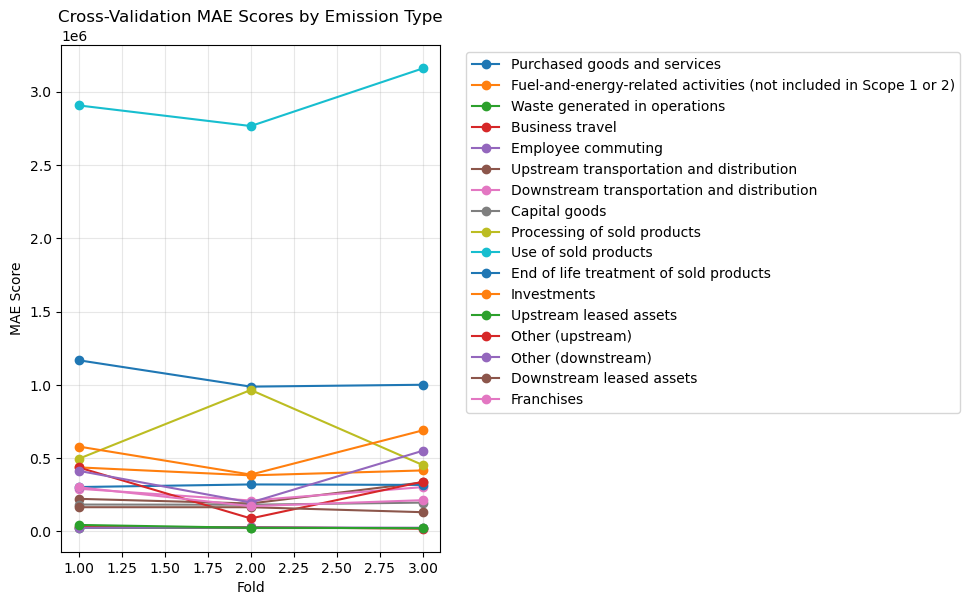

In [125]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot a line for each emission type
for result in cv_results:
    emission_type = result['emission_type']
    # Extract fold numbers and MAE scores
    folds = [score['fold'] for score in result['fold_scores']]
    mae_scores = [score['mae'] for score in result['fold_scores']]
    
    # Plot line
    plt.plot(folds, mae_scores, marker='o', label=emission_type)

# Customize the plot
plt.xlabel('Fold')
plt.ylabel('MAE Score')
plt.title('Cross-Validation MAE Scores by Emission Type')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

The MAE is generally consistent across 3 cross validation folds.

### Final Average Metrics

In [141]:
# Create lists to store metric averages for each emissions type
rows = []
for emission_type, metrics in results_dict.items():
    # Calculate average actual and predicted values
    avg_actual = np.mean(metrics['actuals'])
    avg_predicted = np.mean(metrics['predictions'])
    
    # Create a row for each emission type
    row = {
        'Emission_Type': emission_type,
        'MAE': metrics['mae'],
        'Avg_Actual': avg_actual,
        'Avg_Predicted': avg_predicted,
        'Samples': len(metrics['actuals'])
    }
    rows.append(row)

# Create DataFrame
rf_avg_results = pd.DataFrame(rows)

# Round numerical columns to 4 decimal places
numeric_columns = ['MAE', 'Avg_Actual', 'Avg_Predicted']
rf_avg_results[numeric_columns] = rf_avg_results[numeric_columns].round(4)

# Sort by MAE
rf_avg_results = rf_avg_results.sort_values('MAE')

# Display the DataFrame
print("\n Random Forest Model Performance by Emission Type:")
rf_avg_results


Model Performance by Emission Type:


Emission_Type        MAE  Avg_Actual  \
2                       Waste generated in operations   19413.07    26723.97   
3                                     Business travel   19577.21    15760.04   
4                                  Employee commuting   20153.99    38113.19   
12                             Upstream leased assets   24736.34    20308.79   
15                           Downstream leased assets  130983.27   169592.96   
7                                       Capital goods  176773.18   271175.10   
16                                         Franchises  178530.20   631598.31   
6          Downstream transportation and distribution  271525.69   272791.56   
10             End of life treatment of sold products  290367.06   432906.21   
13                                   Other (upstream)  306387.13   295763.92   
5            Upstream transportation and distribution  331606.25   387384.93   
14                                 Other (downstream)  358011.72   657785.63   
1   Fuel-and-energy-related activities (not includ...  404306.31   689840.23   
8                         Processing of sold products  446692.12   734400.85   
11                                        Investments  689797.91   680564.39   
0                        Purchased goods and services  945559.11  2498771.76   
9                                Use of sold products 2920924.53  5580055.72   

    Avg_Predicted  Samples  
2        30465.71      756  
3        20698.38      848  
4        38051.75      741  
12       28179.78      227  
15      198287.04      219  
7       276849.13      578  
16      609694.06       68  
6       404903.31      346  
10      393886.69      401  
13      598999.93       26  
5       489236.36      618  
14      473021.52       20  
1       605070.03      747  
8       766599.40      117  
11      494890.81      200  
0      2470476.85      798  
9      6309917.46      400

## XGBoost

#### *Build the Model*

In [253]:
# Initialize results storage
results_dict = {}

# Get unique emission types
emission_types = df['Scope_3_emissions_type'].unique()

# Identify numeric columns to scale (excluding Year, target, and encoded categorical features)
all_numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
columns_to_scale = [col for col in all_numeric_columns 
                   if col not in ['Year', 'Scope_3_emissions_amount','account_id']
                   and not col.startswith(('sector_', 'activity_'))]
categorical_columns = [col for col in df.columns 
                      if col.startswith(('sector_', 'activity_'))]

# Create preprocessing steps for StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Get feature names after preprocessing
feature_names = (columns_to_scale + 
                ['Year'] + 
                categorical_columns)

# Create pipeline with preprocessor and XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1  # Use all available cores
    ))
])

for emission_type in emission_types:
    # Filter data for current emission type
    emission_df = df[df['Scope_3_emissions_type'] == emission_type].copy()
    
    # Sort by Year to ensure chronological order
    emission_df = emission_df.sort_values('Year')
    
    # Get the most recent year
    max_year = emission_df['Year'].max()
    
    # Split data into train (previous years) and test (most recent year)
    train_data = emission_df[emission_df['Year'] < max_year]
    test_data = emission_df[emission_df['Year'] == max_year]
    
    # Prepare features and target
    X_train = train_data[columns_to_scale + ['Year'] + categorical_columns].copy()
    y_train = train_data['Scope_3_emissions_amount']
    
    X_test = test_data[columns_to_scale + ['Year'] + categorical_columns].copy()
    y_test = test_data['Scope_3_emissions_amount']
    
    # Fit pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate MAE
    mae = np.mean(np.abs(y_test - y_pred))
    
    # Store results in dictionary with emission_type as key
    results_dict[emission_type] = {
        'mae': mae,
        'actuals': y_test.tolist(),
        'predictions': y_pred.tolist(),
        'prediction_year': max_year
    }

# Print MAE for each emission type
print("\nMAE by Emission Type for Most Recent Year:")
for emission_type, metrics in results_dict.items():
    print(f"Emission Type: {emission_type}")
    print(f"Prediction Year: {metrics['prediction_year']}")
    print(f"MAE: {metrics['mae']:,.2f}")
    print(f"Number of predictions: {len(metrics['predictions'])}")
    print("-" * 50)


MAE by Emission Type for Most Recent Year:
Emission Type: Purchased goods and services
Prediction Year: 2023
MAE: 1,180,673.41
Number of predictions: 798
--------------------------------------------------
Emission Type: Fuel-and-energy-related activities (not included in Scope 1 or 2)
Prediction Year: 2023
MAE: 476,341.60
Number of predictions: 747
--------------------------------------------------
Emission Type: Waste generated in operations
Prediction Year: 2023
MAE: 26,530.70
Number of predictions: 756
--------------------------------------------------
Emission Type: Business travel
Prediction Year: 2023
MAE: 15,075.08
Number of predictions: 848
--------------------------------------------------
Emission Type: Employee commuting
Prediction Year: 2023
MAE: 22,034.33
Number of predictions: 741
--------------------------------------------------
Emission Type: Upstream transportation and distribution
Prediction Year: 2023
MAE: 356,878.18
Number of predictions: 618
---------------------

In [263]:
# Convert results dictionary to DataFrame
xgb_results = pd.DataFrame([
    {
        'emission_type': emission_type,
        'actuals': actual,
        'predictions': pred,
        'mae': mae
    }
    for emission_type, results in results_dict.items()
    for actual, pred in zip(results['actuals'], results['predictions'])
])
xgb_results

emission_type    actuals  predictions       mae
0     Purchased goods and services    1807.00    115996.20 224395.97
1     Purchased goods and services      90.00    263922.16 224395.97
2     Purchased goods and services      65.48    248669.42 224395.97
3     Purchased goods and services 2663484.05    975353.88 224395.97
4     Purchased goods and services    5544.00    217033.06 224395.97
...                            ...        ...          ...       ...
7105                    Franchises  475576.00    328400.31 224395.97
7106                    Franchises     277.00     10498.38 224395.97
7107                    Franchises 2972102.00   2353673.50 224395.97
7108                    Franchises   15358.00     22409.08 224395.97
7109                    Franchises    2407.00     29348.01 224395.97

[7110 rows x 4 columns]

#### *Vizualize Results*

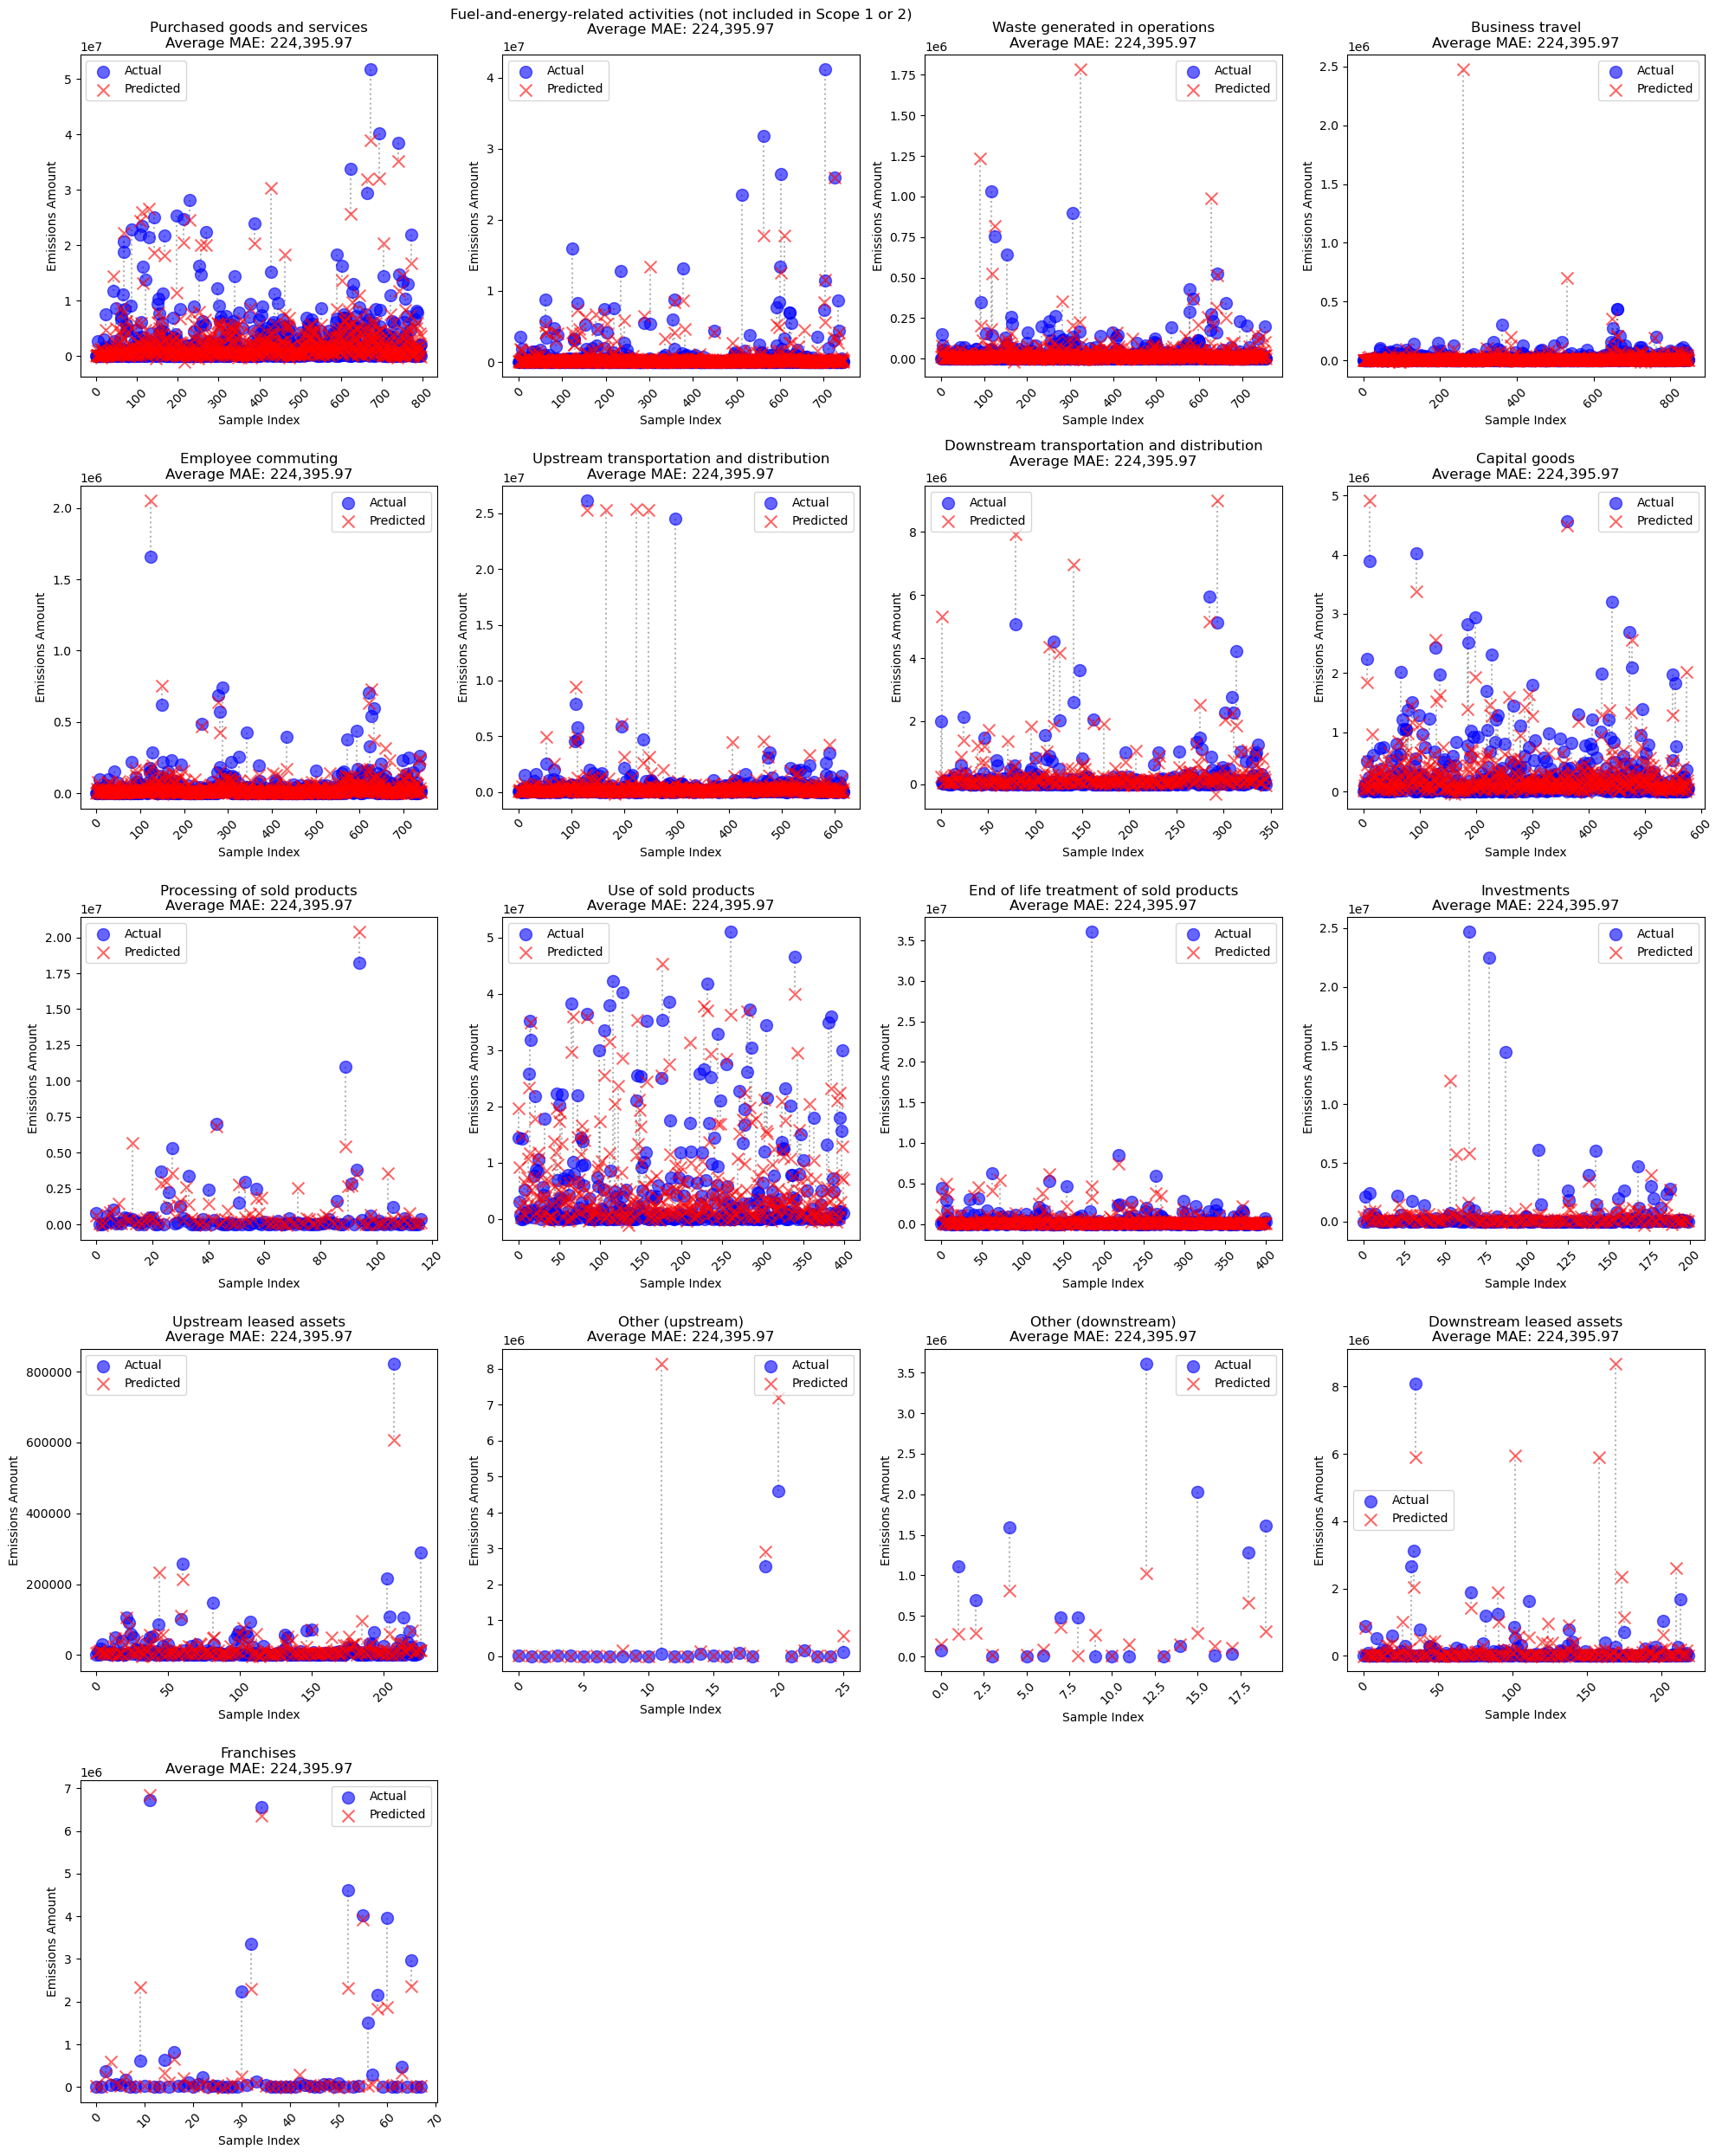

In [268]:
# Calculate number of rows needed for 4 columns
n_types = len(xgb_results['emission_type'].unique())
n_cols = 4
n_rows = (n_types + 3) // 4  # Ceiling division to ensure enough rows

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# For each emission type
for idx, emission_type in enumerate(xgb_results['emission_type'].unique()):
    ax = axes[idx]
    
    # Get data for this emission type
    data = xgb_results[xgb_results['emission_type'] == emission_type]
    actuals = data['actuals'].values
    predictions = data['predictions'].values
    mae = data['mae'].iloc[0]  # Get MAE (same for all rows of this type)
    
    # Plot actual values (blue dots)
    ax.scatter(range(len(actuals)), actuals, color='blue', alpha=0.6, 
              label='Actual', s=100, zorder=1)
    
    # Plot predicted values (red x's)
    ax.scatter(range(len(predictions)), predictions, color='red', alpha=0.6,
              marker='x', s=100, label='Predicted', zorder=2)
    
    # Draw dotted lines between actual and predicted values
    for i in range(len(actuals)):
        ax.plot([i, i], [actuals[i], predictions[i]], 'k:', alpha=0.3, zorder=0)
    
    # Add title and labels
    ax.set_title(f"{emission_type}\nAverage MAE: {mae:,.2f}")
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Emissions Amount')
    ax.legend()
    
    # Rotate x-axis labels if needed
    plt.setp(ax.get_xticklabels(), rotation=45)

# Remove any empty subplots
for idx in range(len(xgb_results['emission_type'].unique()), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

# Prediction Variance

In [270]:
# Calculate variances for each emission type with individual prediction details
variance_data = []
prediction_index = 0

for emission_type, data in results_dict.items():
    actuals = np.array(data['actuals'])
    predictions = np.array(data['predictions'])
    
    # Calculate differences (variance) between actual and predicted
    variances = (actuals - predictions)
    
    # Store data for each individual prediction
    for actual, predicted, variance in zip(actuals, predictions, variances):
        variance_data.append({
            'Emission_Type': emission_type,
            'Actual': actual,
            'Predicted': predicted,
            'Variance': variance,
            'Prediction_Index': prediction_index
        })
        prediction_index += 1

# Convert to DataFrame
variance_df = pd.DataFrame(variance_data)
variance_df

Emission_Type     Actual  Predicted   Variance  \
0     Purchased goods and services    1807.00  115996.20 -114189.20   
1     Purchased goods and services      90.00  263922.16 -263832.16   
2     Purchased goods and services      65.48  248669.42 -248603.94   
3     Purchased goods and services 2663484.05  975353.88 1688130.17   
4     Purchased goods and services    5544.00  217033.06 -211489.06   
...                            ...        ...        ...        ...   
7105                    Franchises  475576.00  328400.31  147175.69   
7106                    Franchises     277.00   10498.38  -10221.38   
7107                    Franchises 2972102.00 2353673.50  618428.50   
7108                    Franchises   15358.00   22409.08   -7051.08   
7109                    Franchises    2407.00   29348.01  -26941.01   

      Prediction_Index  
0                    0  
1                    1  
2                    2  
3                    3  
4                    4  
...                ...  
7105              7105  
7106              7106  
7107              7107  
7108              7108  
7109              7109  

[7110 rows x 5 columns]

#### **Prediction Variance**: *Scatterplot of all Predictions by Emissions Type*

In [273]:
# Sort the DataFrame by Emission_Type to group colors together
variance_df = variance_df.sort_values(['Emission_Type', 'Prediction_Index'])

# Create figure with secondary y-axis
fig = make_subplots(
    rows=1, 
    cols=2,
    column_widths=[0.7, 0.3],  # 70% for plot, 30% for legend
    specs=[[{"type": "scatter"}, {"type": "table"}]]
)

# Function to generate distinct colors based on index
def get_color(idx):
    # Using HSL color space for better distribution of colors
    hue = (idx * 137.5) % 360  # Golden angle approximation for better distribution
    return f'hsl({hue}, 70%, 50%)'

# Add scatter plots for each emission type
for idx, emission_type in enumerate(variance_df['Emission_Type'].unique()):
    temp_df = variance_df[variance_df['Emission_Type'] == emission_type]
    
    # Add scatter trace
    fig.add_trace(
        go.Scatter(
            x=temp_df['Prediction_Index'],
            y=temp_df['Variance'],
            name=emission_type,
            mode='markers',
            marker=dict(
                color=get_color(idx),
                size=5,
                opacity=0.4,
                symbol='circle'
            ),
            hovertemplate=(
                "<b>%{text}</b><br>" +
                "Index: %{x}<br>" +
                "Variance: %{y:.2f}<br>" +
                "<extra></extra>"
            ),
            text=[emission_type] * len(temp_df)
        ),
        row=1, col=1  # Place in first column
    )

# Add reference line at y=0
fig.add_hline(
    y=0, 
    line_dash="dash", 
    line_color="black",
    row=1, col=1
)

# Create legend as a separate table with colored dots
legend_data = [
    [f'⬤ {emission_type}']  # Unicode circle + emission type
    for idx, emission_type in enumerate(variance_df['Emission_Type'].unique())
]

fig.add_trace(
    go.Table(
        header=dict(values=['Emission Types'],
                   fill_color='white',
                   font=dict(size=10)),
        cells=dict(
            values=[legend_data],
            fill_color='white',
            font=dict(size=8),
            height=25,
            align='left',
            # Add colors to the cells
            font_color=[
                [get_color(idx) for idx, _ in enumerate(variance_df['Emission_Type'].unique())]
            ]
        ),
        columnwidth=[1]
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title={
        'text': 'Prediction Variances by Emission Type',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1000,
    height=600,
    template='simple_white',
    showlegend=False,  # Hide default legend
    xaxis=dict(
        title='Prediction',
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    yaxis=dict(
        title='Variance',
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    margin=dict(r=20, l=20, t=50, b=20)
)

# Update the second subplot to remove axes
fig.update_xaxes(showticklabels=False, showgrid=False, row=1, col=2)
fig.update_yaxes(showticklabels=False, showgrid=False, row=1, col=2)

# Show the plot
fig.show()

In [280]:
#### **Prediction Variance**: *Actuals vs Predicted for Each Emissions Type*

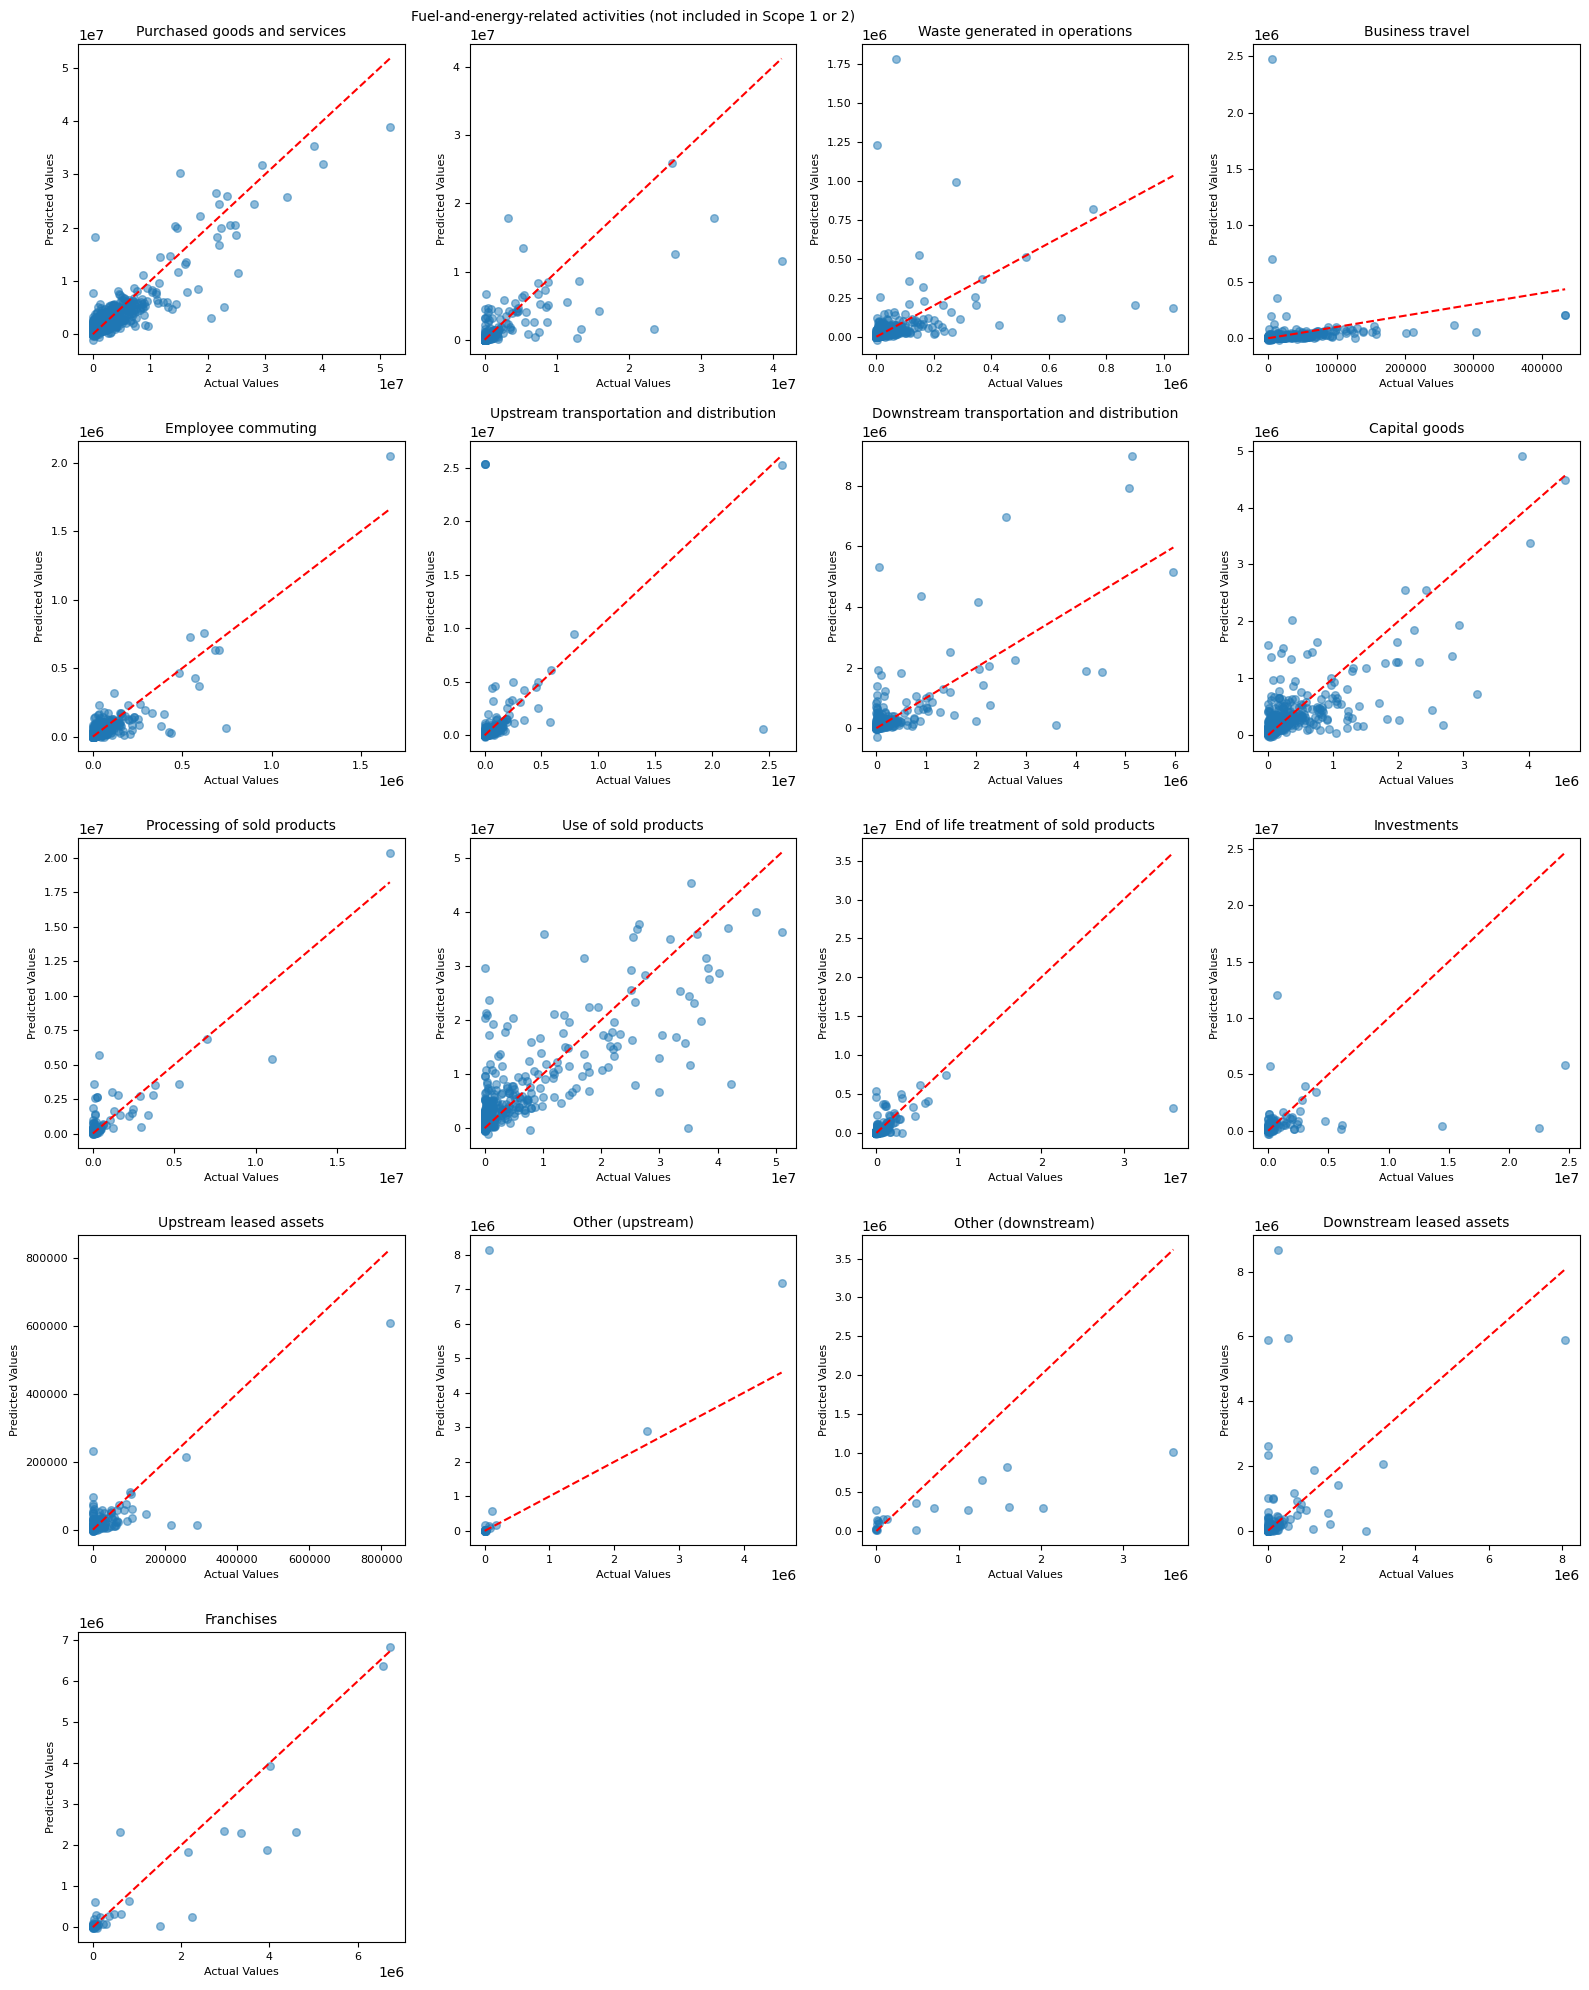

In [276]:
# Actual vs Predicted Scatter Plots
n_types = len(results_dict)
n_cols = 4
n_rows = (n_types + 3) // 4  

plt.figure(figsize=(16, 4*n_rows))  

for i, (emission_type, data) in enumerate(results_dict.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(data['actuals'], data['predictions'], alpha=0.5, s=30)  
    plt.plot([min(data['actuals']), max(data['actuals'])], 
             [min(data['actuals']), max(data['actuals'])], 'r--')
    plt.xlabel('Actual Values', fontsize=8)  
    plt.ylabel('Predicted Values', fontsize=8)  
    plt.title(f'{emission_type}', fontsize=10)  
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8)  

plt.tight_layout()
plt.show()

### Final Average Metrics

In [287]:
# Create lists to store metric averages for each emissions type
rows = []
for emission_type, metrics in results_dict.items():
    # Calculate average actual and predicted values
    avg_actual = np.mean(metrics['actuals'])
    avg_predicted = np.mean(metrics['predictions'])
    
    # Create a row for each emission type
    row = {
        'Emission_Type': emission_type,
        'MAE': metrics['mae'],
        'Avg_Actual': avg_actual,
        'Avg_Predicted': avg_predicted,
        'Samples': len(metrics['actuals'])
    }
    rows.append(row)

# Create DataFrame
xgb_avg_results = pd.DataFrame(rows)

# Round numerical columns to 4 decimal places
numeric_columns = ['MAE', 'Avg_Actual', 'Avg_Predicted']
xgb_avg_results[numeric_columns] = xgb_avg_results[numeric_columns].round(4)

# Sort by MAE
xgb_avg_results = xgb_avg_results.sort_values('MAE')

# Display the DataFrame
print("\nXGBoost Model Performance by Emission Type:")
xgb_avg_results


XGBoost Model Performance by Emission Type:


Emission_Type        MAE  Avg_Actual  \
3                                     Business travel   15075.08    15760.04   
12                             Upstream leased assets   15802.89    20308.79   
4                                  Employee commuting   22034.33    38113.19   
2                       Waste generated in operations   26530.70    26723.97   
7                                       Capital goods  183785.92   271175.10   
16                                         Franchises  224395.97   631598.31   
15                           Downstream leased assets  234006.16   169592.96   
6          Downstream transportation and distribution  247373.78   272791.56   
10             End of life treatment of sold products  328169.50   432906.21   
5            Upstream transportation and distribution  356878.18   387384.93   
13                                   Other (upstream)  459356.00   295763.92   
1   Fuel-and-energy-related activities (not includ...  476341.60   689840.23   
14                                 Other (downstream)  484809.30   657785.63   
8                         Processing of sold products  501289.49   734400.85   
11                                        Investments  689758.37   680564.39   
0                        Purchased goods and services 1180673.41  2498771.76   
9                                Use of sold products 3571694.40  5580055.72   

    Avg_Predicted  Samples  
3        14871.10      848  
12       19846.54      227  
4        37450.07      741  
2        32557.94      756  
7       269808.56      578  
16      513298.20       68  
15      271253.14      219  
6       356077.11      346  
10      392403.30      401  
5       496463.61      618  
13      752671.92       26  
1       588459.31      747  
14      257557.72       20  
8       901384.61      117  
11      440292.44      200  
0      2463119.70      798  
9      6233605.83      400

### Compare XGBoost and Random Forest Models

In [310]:
# Compare XGBoost and Random Forest results
comparison_df = pd.DataFrame({
    'Emission_Type': xgb_avg_results['Emission_Type'],
    'XGB_MAE': xgb_avg_results['MAE'],
    'RF_MAE': rf_avg_results['MAE'],
    'XGB_Pred': xgb_avg_results['Avg_Predicted'],
    'RF_Pred': rf_avg_results['Avg_Predicted'],
    'Actual': xgb_avg_results['Avg_Actual']
})

# Calculate improvements
comparison_df['MAE_Improvement'] = ((comparison_df['RF_MAE'] - comparison_df['XGB_MAE']) / comparison_df['RF_MAE']) * 100
comparison_df['Pred_Improvement'] = (abs(comparison_df['RF_Pred'] - comparison_df['Actual']) - 
                                   abs(comparison_df['XGB_Pred'] - comparison_df['Actual'])) / abs(comparison_df['RF_Pred'] - comparison_df['Actual']) * 100

# Calculate average metrics
avg_metrics = {
    'Average XGB MAE': comparison_df['XGB_MAE'].mean(),
    'Average RF MAE': comparison_df['RF_MAE'].mean(),
    'Overall MAE Improvement (%)': comparison_df['MAE_Improvement'].mean(),
    'Overall Prediction Improvement (%)': comparison_df['Pred_Improvement'].mean()
}

# Print overall performance metrics
print("Overall Performance Metrics:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.2f}")

# Determine overall better model
better_model = "XGBoost" if avg_metrics['Overall MAE Improvement (%)'] > 0 else "Random Forest"
print(f"\nOverall Better Model: {better_model}")

# Print emission-type specific performance
print("\nPerformance by Emission Type:")
print("-" * 60)
for _, row in comparison_df.iterrows():
    better_model_type = "XGBoost" if row['MAE_Improvement'] > 0 else "Random Forest"
    improvement = abs(row['MAE_Improvement'])
    print(f"Emission Type: {row['Emission_Type']}")
    print(f"Better Model: {better_model_type}")
    print(f"XGB MAE: {row['XGB_MAE']:.2f}")
    print(f"RF MAE: {row['RF_MAE']:.2f}")
    print(f"Improvement: {improvement:.2f}%")
    print("-" * 60)

Overall Performance Metrics:
Average XGB MAE: 530469.12
Average RF MAE: 443255.59
Overall MAE Improvement (%): -15.85
Overall Prediction Improvement (%): -123.64

Overall Better Model: Random Forest

Performance by Emission Type:
------------------------------------------------------------
Emission Type: Purchased goods and services
Better Model: Random Forest
XGB MAE: 1180673.41
RF MAE: 945559.11
Improvement: 24.87%
------------------------------------------------------------
Emission Type: Fuel-and-energy-related activities (not included in Scope 1 or 2)
Better Model: Random Forest
XGB MAE: 476341.60
RF MAE: 404306.31
Improvement: 17.82%
------------------------------------------------------------
Emission Type: Waste generated in operations
Better Model: Random Forest
XGB MAE: 26530.70
RF MAE: 19413.07
Improvement: 36.66%
------------------------------------------------------------
Emission Type: Business travel
Better Model: XGBoost
XGB MAE: 15075.08
RF MAE: 19577.21
Improvement: 2

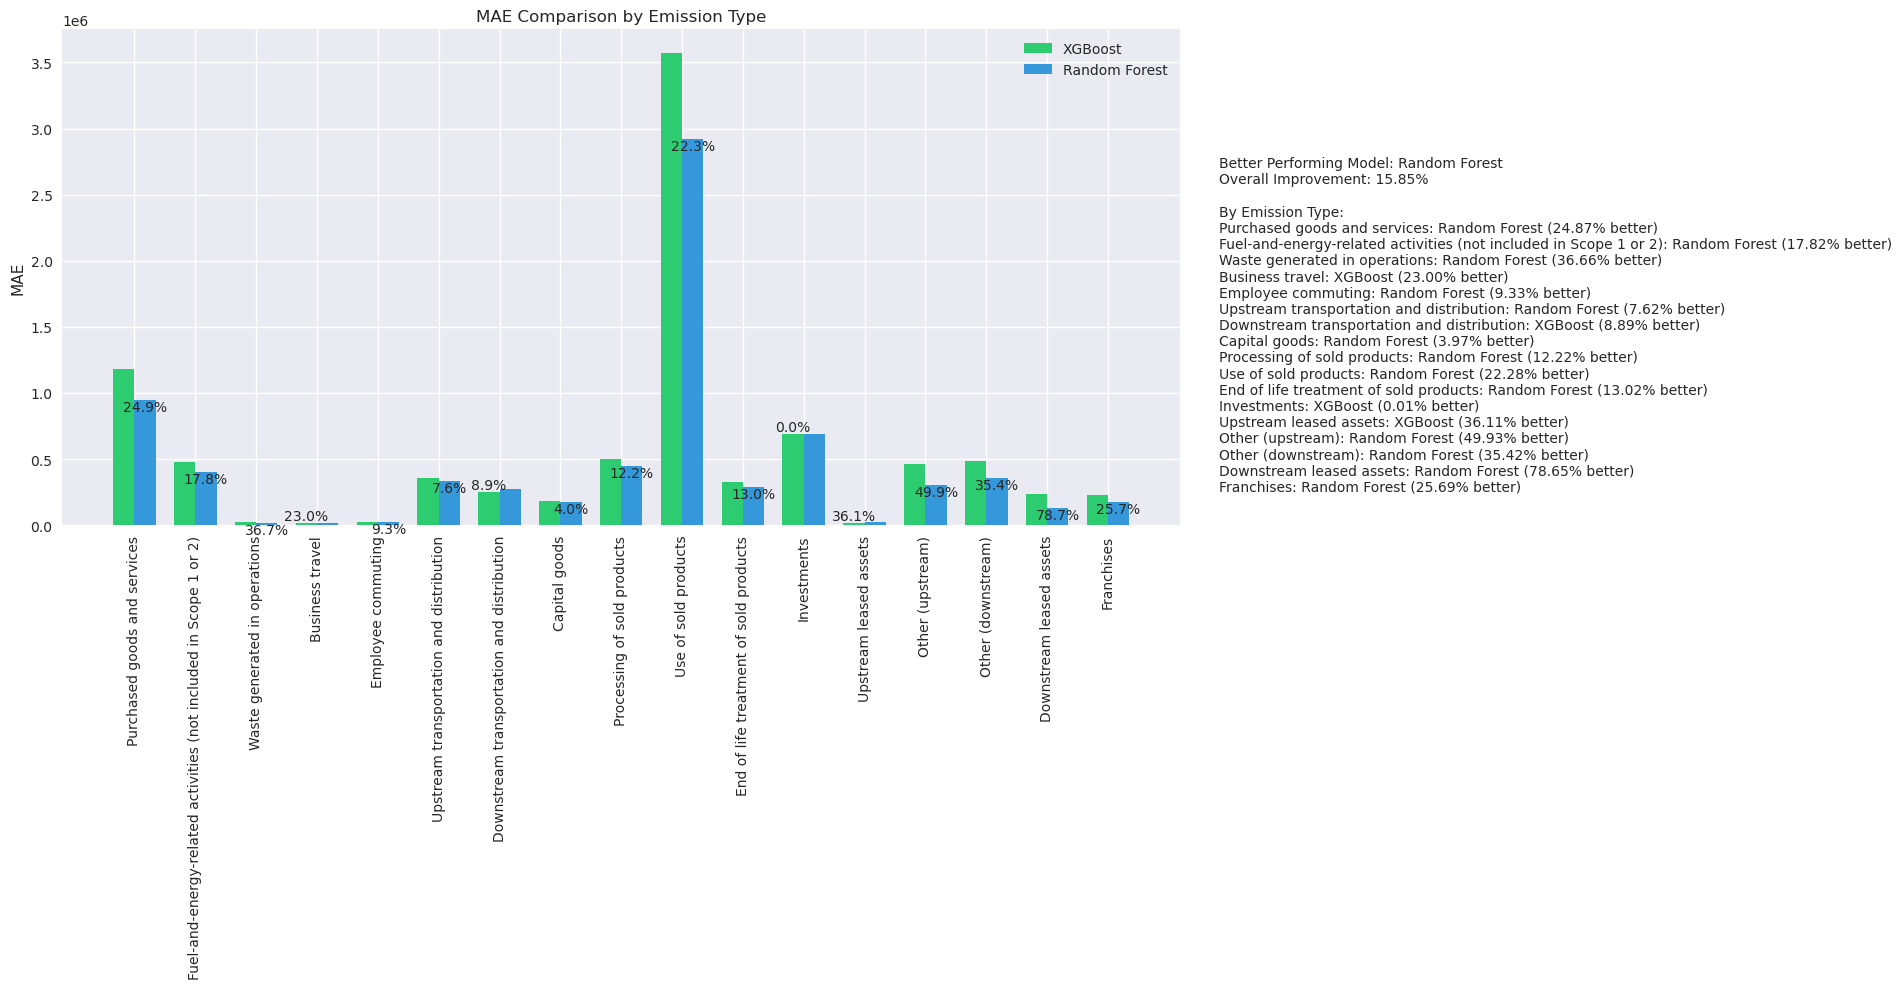


Overall Performance Metrics:
Average XGB MAE: 530469.12
Average RF MAE: 443255.59
Overall MAE Improvement (%): -15.85
Overall Prediction Improvement (%): -123.64


In [327]:
# Set style and figure size
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 10))

# Create vertical bar plot
bar_width = 0.35
x = np.arange(len(comparison_df['Emission_Type']))
bars1 = ax.bar(x - bar_width/2, comparison_df['XGB_MAE'], bar_width, label='XGBoost', color='#2ecc71')
bars2 = ax.bar(x + bar_width/2, comparison_df['RF_MAE'], bar_width, label='Random Forest', color='#3498db')

# Customize plot
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison by Emission Type')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Emission_Type'], rotation=90)
ax.legend()

# Add improvement percentages above better performing bars
for idx, row in comparison_df.iterrows():
    improvement = abs(row['MAE_Improvement'])
    if row['MAE_Improvement'] > 0:  # XGBoost is better
        height = row['XGB_MAE']
        position = idx - bar_width/2
        ax.text(position, height, f'{improvement:.1f}%', 
                ha='center', va='bottom')
    else:  # Random Forest is better
        height = row['RF_MAE']
        position = idx + bar_width/2
        ax.text(position, height, f'{improvement:.1f}%', 
                ha='center', va='top')

# Add overall metrics and performance text
overall_better = "XGBoost" if avg_metrics['Overall MAE Improvement (%)'] > 0 else "Random Forest"
overall_improvement = abs(avg_metrics['Overall MAE Improvement (%)'])

performance_text = f"Better Performing Model: {overall_better}\nOverall Improvement: {overall_improvement:.2f}%\n\nBy Emission Type:"

for _, row in comparison_df.iterrows():
    better_model = "XGBoost" if row['MAE_Improvement'] > 0 else "Random Forest"
    improvement = abs(row['MAE_Improvement'])
    performance_text += f"\n{row['Emission_Type']}: {better_model} ({improvement:.2f}% better)"

plt.figtext(1.02, 0.5, performance_text, fontsize=10, va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print the performance metrics
print("\nOverall Performance Metrics:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.2f}")

#### **Analyzing MAE and Model Performance**

MAE measures the average magnitude of errors between predicted and actual values. It is measured with the same unit as the target variable (CO2). Standard Deviation (σ) represents the natural variability and spread of the data and is used to indicate how much actual values deviate from the mean. In general, the higher the STD, the harder it is to predict a target. While the STD was dramatically reduced in the previous outlier and normalization process, the STD remained high across emission types and primary activities. A quick review of the plot outputs allows you to visually see how close each prediction was to the actual observation. The MAE metric for each emissions type is the average of all predictions for every observation within that category.

For both models, the MAE is significantly lower than the standard deviation, which indicates pretty decent prediction performance, but only in comparison to natural variation, especially considering the extreme variability of the data and how spread-out it is. It could likely be improved with more outlier removal and normalization since the STD is sensitive to outliers. Unfortunatly, the features didn't offer a lot of strong correlation, so it is likely more the time-series trend that offered the most prediction power, but deeper analysis would help better understand feature correlation and importance for an improved model. The lowest possible level of detail in this dataset is the Primary Activity, which is categorical and requires encoding for use in most machine learning models. Features that offer deeper level of detail and are directly correlated to emission amount would vastly improve prediction strength. As an example, within the Business travel emission type, knowing the size of the company's vehicle fleet or the amount of annual airplane travel would certainly offer more information for the model to use. 

Comparing XGBoost to Random Forest, XGBoost seems to perform slightly better with an average MAE/STD ratio of .34 and is potentially a better suited model in this specific scenario. The ratios indicate the model has learned meaningful patterns in the data.

**Outcome**:
- The model's predictions are more accurate than what you'd expect from the natural variation in the data
- The model has successfully captured some underlying patterns beyond random variation
- The predictions are more reliable than simply using the mean value
- The model is performing well relative to the inherent variability and spread in the data

#### **Further Research**

1. Benchmarking against XGBoost and Random Forest
2. Enhanced Feature Engineering - Dividing Emission Amount by Total Liabilities (Highest correlation), techniques to predict targets without time series evaluation
3. Industry validation, especially on extreme outliers
4. Continued normalization, skew transformation, and outlier analysis with possible imputation
5. Testing models on nulls and testing ensemble approaches
6. Testing Deep Learning and Neural Networks:
    - More complex pattern recognition (identify noin-linear relationships, adapt to changing patterns)
    - Better time series prediction
    - Better handling of high-dimensional data with automatic feature extraction
    - Better incorporate categorical data like Primary activity or Sector

In [ ]:
# Calculate average variance for each emission type
variance_data = []
for emission_type, data in results_dict.items():
    actuals = np.array(data['actuals'])
    predictions = np.array(data['predictions'])
    
    # Calculate absolute differences (variance) between actual and predicted
    variances = np.abs(actuals - predictions)
    
    # Store data
    for var in variances:
        variance_data.append({
            'Emission_Type': emission_type,
            'Variance': var
        })

# Convert to DataFrame
df_variance = pd.DataFrame(variance_data)
df_variance